# Anomaly datection in HPC: CINECA Marconi-100
## UNIBO Artificial Intelligence for Industry a.y. 2020/2021
### Daniele Verì
### Report available on [Wegths and Biases](https://wandb.ai/veri/hpc/reports/Anomaly-detection-in-HPC-CINECA-Marconi-100--Vmlldzo5NjE5Mzc)

# Definitions
This block contains all imports and definition used in the notebook.

## Preprocessing

In [1]:
#@title Loading

import os
import pandas as pd

def download_data():
    os.system("wget https://api.wandb.ai/artifactsV2/gcp-us/veri/QXJ0aWZhY3Q6MTc5MTY4NTY=/a8b54a07b9c70170d5844b3c46abf28c -O data_m100.zip")
    print("Download complete")
    os.system("unzip data_m100.zip")
    print("Extraction complete")

def load_node(node_name):
    data = pd.read_parquet('new_data/{}'.format(node_name))
    if len(data.index) > 0:
        data[data.columns[1:]] = data[data.columns[1:]].astype('float32')
    return data

def get_node_list():
    nodes = next(os.walk('new_data'))[2]
    nodes.sort()
    return nodes

def fix_columns_names(node_df):
    cols = node_df.columns[153:153+64].tolist()
    replace = {}
    for i,c in enumerate(cols):
        replace[c] = c[:4]+"p0_core{}_temp".format(i//4)
    cols = node_df.columns[153+64+16:153+64+16+64].tolist()
    for i,c in enumerate(cols):
        replace[c] = c[:4]+"p1_core{}_temp".format(i//4)
    return node_df.rename(columns=replace, inplace=True)

def load_nodes(node_names):
    nodes = []
    for n in node_names:
        tmp = load_node(n)
        if len(tmp.index) == 0:
            continue
        fix_columns_names(tmp)
        nodes.append(tmp)
        print("loaded node", n)
    return nodes

In [2]:
#@title Timeseries processing

import numpy as np
from sklearn.metrics import mean_squared_error

def look_sample_freq(node):
    delta = (node['timestamp']-node['timestamp'].shift(periods=1)).astype('timedelta64[m]')
    vc = pd.Series(delta).value_counts()
    sorted = vc.keys().tolist()
    sorted.sort()
    for i in range(12):
        k=sorted[i]
        print("{} : {}".format(k, vc[k]))

def extract_contiguous_data(dense_node):
    dropped = dense_node.dropna()
    deltas = dropped.index[1:] - dropped.index[:-1]
    bool_list = deltas == pd.Timedelta('15min')
    subseq = np.split(bool_list, np.argwhere(bool_list == False).flatten())
    lengths = np.vectorize(len)(np.array(subseq, dtype=object))
    argmax = np.argmax(lengths)
    start = np.sum(lengths[:argmax])+1
    chunk = dropped.iloc[start:start+lengths[argmax]]
    return chunk

def filling_performance(contiguous_chunk, mv_num=30):
    mv_starts = np.random.choice(
        range(1, len(contiguous_chunk.index)-mv_num-1), mv_num, replace=False)
    mv_starts.sort()
    contiguous_chunk_mv = contiguous_chunk.copy()
    for i in range(mv_num):
        contiguous_chunk_mv.iloc[mv_starts[i]:mv_starts[i]+i+1] = np.NaN
    ffseries = contiguous_chunk_mv.fillna(method='ffill')
    bfseries = contiguous_chunk_mv.fillna(method='bfill')
    liseries = contiguous_chunk_mv.interpolate(method='linear')
    nnseries = contiguous_chunk_mv.interpolate(method='nearest')
    # polynomial always performs poorly
    rmse_ff = np.sqrt(mean_squared_error(contiguous_chunk, ffseries))
    rmse_bf = np.sqrt(mean_squared_error(contiguous_chunk, bfseries))
    rmse_li = np.sqrt(mean_squared_error(contiguous_chunk, liseries))
    rmse_nn = np.sqrt(mean_squared_error(contiguous_chunk, nnseries))
    return {
        'ffill': rmse_ff,
        'bfill': rmse_bf,
        'linear': rmse_li,
        'nearest': rmse_nn }

def max_normalize(dense_node):
    copy = dense_node.copy()
    for c in copy.columns:
        max_col = copy[c].max()
        if max_col != 0:
            copy[c] /= max_col
    return copy

def densify_time_series(node, freq='15min'):
    dindex = pd.date_range(
        node['timestamp'].iloc[0], node['timestamp'].iloc[-1], freq=freq)
    ddata = pd.DataFrame(index=dindex, columns=node.columns)
    ddata = ddata.drop(columns='timestamp')
    node = node.set_index('timestamp')
    node.index = node.index.round(freq=freq)
    node = node[~node.index.duplicated()]
    ddata[:] = node[:]
    return ddata

def fill_and_shift(dense_node, fill_limit, max_window_size):
    features, labels = dense_node.columns[:-2], dense_node.columns[-2:]
    dense_node[features] = dense_node[features].interpolate(
        method='linear', limit=fill_limit)
    dense_node[labels] = dense_node[labels].interpolate(
        method='nearest', limit=fill_limit)
    for i in range(1, max_window_size+1):
        shifted = dense_node['New_label'].shift(periods=-i, fill_value=-1)
        dense_node[f'label_shift_{i}'] = shifted
    return dense_node.dropna()

def generate_window(data, win_size):
    q = 'New_label > 0'
    for i in range(1, win_size+1):
        q += f'or label_shift_{str(i)} > 0'
    l = pd.Series(0, index=data.index)
    l.loc[data.query(q).index] = 1
    return l


In [3]:
#@title Data split

import random 

def train_val_test_split(nodes, split=[0.9, 0.05]):
    val_nodes = int(split[1] * len(nodes))
    test_nodes = int((1-split[0]-split[1]) * len(nodes))
    random.shuffle(nodes)
    train_data = nodes[test_nodes+val_nodes:]
    val_data = nodes[test_nodes:test_nodes+val_nodes]
    test_data = nodes[:test_nodes]
    return train_data, val_data, test_data

In [4]:
#@title Normalize and standardize

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None

class SmartScaler:
    def __init__(self, nodes):
        def scaler_worker(c):
            rs = RobustScaler()
            ss = StandardScaler()
            col = pd.Series(dtype=float)
            for n in nodes:
                col = col.append(n[c])
            col = col.to_numpy().reshape(-1,1)
            rs.fit(col)
            scaled = rs.transform(col)
            ss.fit(scaled)
            print(f"processed col {c}")
            return rs, ss

        self.original_features = nodes[0].columns[:460]
        self.scaler = list(map(scaler_worker, self.original_features))

        # drop columns with 0 var
        vars = []
        for s in self.scaler:
            s = s[1] #std scaler
            vars.append(s.var_)
        vars = np.array(vars)
        self.droppable = self.original_features[(vars == 0).squeeze()]
        self.droppable = self.droppable.drop('var:boottime')
        self.features = self.original_features.drop(self.droppable)
        print(f"Columns with 0 variance: {self.droppable}")

    def transform(self, df):
        for i in range(len(self.original_features)):
            col = df[self.original_features[i]].copy().to_numpy().reshape(-1,1)
            robust_scaled = self.scaler[i][0].transform(col)
            df.loc[:,self.original_features[i]] = self.scaler[i][1].transform(robust_scaled)
        df.drop(self.droppable, axis=1, inplace=True)


## Visualization

In [5]:
#@title Node visualization

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard

from tensorboard.plugins import projector
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

def plot_heatmap_dataframe(data, vmin=-1.96, vmax=1.96, figsize=(18 ,6)):
    labels = pd.Series(
        index=data.index, data=(data['New_label'] != 0), dtype=int)
    plt.close('all')
    plt.figure(figsize=figsize)
    plt.imshow(data.T.iloc[:, :], aspect='auto',
            cmap='RdBu', vmin=vmin, vmax=vmax)
    ncol = len(data.columns)
    lvl = - 0.05 * ncol
    plt.scatter(range(len(labels.index)), np.ones(len(labels)) * lvl,
            s=4,
            color=plt.get_cmap('tab10')(labels))
    plt.tight_layout()

def plot_features_covariance(node):
    X = node[FEATURES].to_numpy()
    pca = PCA(n_components=30)
    pca.fit(X)
    covx = pca.get_covariance()
    print(pca.explained_variance_ratio_)
    plt.figure(figsize=(10,10))
    plt.imshow(covx, interpolation=None)
    plt.show()

def tensorboard_projector(node, max_points=10000):
    log_dir='/content/tensorboard'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    proc = pd.qcut(node['max:proc_total'], 3, 
                   labels=["proctot_l", "proctot_m", "proctot_h"])
    idle = pd.qcut(node['max:cpu_aidle'], 3, 
                   labels=["idle_l", "idle_m", "idle_h"])
    mem = pd.qcut(node['min:mem_free'], 3, 
                   labels=["memfree_l", "memfree_m", "memfree_h"])
    swap = pd.qcut(node['max:swap_free'], 3, 
                   labels=["swap_h", "swap_m", "swap_l"])
    power = pd.qcut(node['avg:ps1_input_power']+node['avg:ps0_input_power'], 3, 
                   labels=["power_l", "power_m", "power_h"])

    out_v = open(os.path.join(log_dir, 'vectors.tsv'), "w")
    out_m = open(os.path.join(log_dir, 'metadata.tsv'), "w")

    for i in range(min(max_points, len(node.index))):
        vec = node.iloc[i][FEATURES]
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")

        tag = str(int(node.iloc[i]['New_label'])) + ","
        tag += f"{proc[i]},{idle[i]},{mem[i]},{swap[i]},{power[i]}"
        out_m.write(tag + "\n")

    out_v.close()
    out_m.close()

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.metadata_path = 'metadata.tsv'
    embedding.tensor_path = 'vectors.tsv'
    projector.visualize_embeddings(log_dir, config)

    %tensorboard --logdir /content/tensorboard/


In [6]:
#@title Metrics visualization

from matplotlib import cm
from matplotlib.ticker import MaxNLocator

def plot_signals(preds, labels):
    fig = plt.figure(figsize=(14,8))
    for i in range(len(preds)):
        plt.subplot(3,1,i+1)
        plt.plot(preds[i].index, preds[i], label='predictions')
        nonzero = preds[i].index[labels[i] != 0]
        smin, smax = np.min(preds[i]),  np.max(preds[i])
        lvl = smin - 0.05 * (smax-smin)
        plt.scatter(nonzero, np.ones(len(nonzero)) * lvl, s=4, color='tab:orange')

    if ENABLE_WANDB: 
        plt.savefig('chart.png')
        wandb.log({"plot_signal": wandb.Image('chart.png')})
    plt.show()

def plot_metrics(tolerance_metric, strict_metric, p, n, th_range):
    # just tolerant metrics, strict_metrics were only used  
    # to check the correctenss.
    tn = tolerance_metric[:,0]
    fp = tolerance_metric[:,1]
    fn = tolerance_metric[:,2]
    tp = tolerance_metric[:,3]
    tot_slack = tolerance_metric[:,4]

    # pr curve
    fig = plt.figure(figsize=(12,8))
    prec = np.array(tp) / (np.array(tp)+np.array(fp))
    rec = np.array(tp) / (np.array(tp)+np.array(fn))
    plt.scatter(prec, rec)
    plt.xlim(0,1)
    plt.plot((1,0),(0,1))
    plt.xlabel('prec', fontsize=12)
    plt.ylabel('rec', fontsize=12)
    plt.title("PR", fontsize=18)
    plt.show()
    if ENABLE_WANDB: 
        data = [[x, y] for (x, y) in zip(prec, rec)]
        table = wandb.Table(data=data, columns = ["prec", "rec"])
        wandb.log({"PR" : wandb.plot.line(table, "prec", "rec",
            title="PR")})

    # tn, fp, fn, tp
    # scale to 0-1 range
    tp/=p; tn/=n; fp/=n; fn/=p;
    fig = plt.figure(figsize=(12,8))
    plt.plot(fp)
    plt.plot(fn)
    plt.plot(tp)
    plt.plot(tn)
    plt.legend(['fp', 'fn', 'tp', 'tn'])
    plt.xlabel('threshold', fontsize=12)
    plt.title("metrics", fontsize=18)
    plt.show()
    if ENABLE_WANDB: 
        wandb.log({"tol-metrics" : wandb.plot.line_series(
            xs=np.linspace(0,1,len(fp)),
            ys=[tn, fp, fn, tp],
            keys=["tn", "fp", "fn", "tp"],
            title="Metrics",
            xname="threshold")})

    # roc curve
    fig = plt.figure(figsize=(12,8))
    plt.scatter(fp, tp)
    plt.plot((0,1),(0,1))
    plt.xlabel('fp', fontsize=12)
    plt.ylabel('tp', fontsize=12)
    plt.title("roc", fontsize=18)
    plt.show()
    if ENABLE_WANDB: 
        data = [[x, y] for (x, y) in zip(fp, tp)]
        table = wandb.Table(data=data, columns = ["fp", "tp"])
        wandb.log({"ROC" : wandb.plot.line(table, "fp", "tp",
            title="ROC")})
    # slack
    fig = plt.figure(figsize=(12,8))
    plt.plot(tot_slack)
    plt.xlabel('threshold', fontsize=12)
    plt.title("total slack", fontsize=18)
    plt.show()
    if ENABLE_WANDB: 
        data = [[x, y] for (x, y) in zip(np.linspace(0,1,len(fp)), tot_slack)]
        table = wandb.Table(data=data, columns = ["threshold", "slack"])
        wandb.log({"slack" : wandb.plot.line(table, "threshold", "slack",
            title="Slack")})

def plot_3d_metrics(tolerance_metric, strict_metric, th_range):
    tolerance_titles = ["true negatives", "false positives", "false negatives", 
                "true positives", "total slack"]
    strict_titles = ["true negatives", "false positives", "false negatives", 
                "true positives", "precision", "recall"]
    def _plot(metric, titles, plt_name):
        fig = plt.figure(figsize=(10,40))

        for i in range(metric.shape[0]):
            metric[i,:,0]/=max(metric[i,:,0])
            metric[i,:,1]/=max(metric[i,:,1])
            metric[i,:,2]/=max(metric[i,:,2])
            metric[i,:,3]/=max(metric[i,:,3])

        x = np.arange(0, metric.shape[0], 1)
        z = np.arange(0, metric.shape[1], 1)
        X, Z = np.meshgrid(x, z)
        
        for i in range(metric.shape[2]):
            m = np.stack(metric[:,:,i])
            ax = fig.add_subplot(metric.shape[2]+1,1,i+1, projection='3d')
            plt.xlabel('window size', fontsize=12)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.ylabel('threshold', fontsize=12)
            plt.title(titles[i], fontsize=18)
            ax.plot_surface(X, Z, np.swapaxes(m, 0,1), cmap=cm.coolwarm)
            ax.view_init(elev=10.,azim=45)

        if ENABLE_WANDB: 
            plt.savefig('chart.png')
            wandb.log({plt_name: wandb.Image('chart.png')})
        plt.show()

    _plot(tolerance_metric, tolerance_titles, "tol_win_opt")
    _plot(strict_metric, strict_titles, "str_win_opt")

def plot_costs(c):
    fig = plt.figure(figsize=(8,12))
    
    titles = ["best thresholds", "best test cost", "auc roc", "ap"]
    for i in range(c.shape[1]):
        fig.tight_layout()
        ax = fig.add_subplot(c.shape[1]+1,1,i+1)
        ax.plot(c[:,i])
        plt.xlabel('window size', fontsize=12)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(titles[i], fontsize=18)
    plt.show()

    if ENABLE_WANDB: 
        data = [[x, y] for (x, y) in zip(list(range(c.shape[0])), c[:,0])]
        table = wandb.Table(data=data, columns = ["win_size", "best threshold"])
        wandb.log({"best threshold" : wandb.plot.line(table, "win_size", "best threshold",
            title="Best threshold")})
        
        data = [[x, y] for (x, y) in zip(list(range(c.shape[0])), c[:,1])]
        table = wandb.Table(data=data, columns = ["win_size", "best test cost"])
        wandb.log({"best test cost" : wandb.plot.line(table, "win_size", "best test cost",
            title="Best test cost")})

        wandb.log({"win-roc-ap" : wandb.plot.line_series(
            xs=list(range(c.shape[0])),
            ys=[c[:,2], c[:,3]],
            keys=["auc roc", "ap"],
            title="AUC ROC - AP",
            xname="win size")})


## Cost model

In [7]:
#@title Metrics and cost model

from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from functools import partial

class CostModel:
    def __init__(self, label_list, prediction_list, th_range):
        assert len(label_list) == len(prediction_list)
        self.label_list = label_list
        self.prediction_list = prediction_list
        self.th_range = th_range

    def get_area_metrics(self):
        avg_ap, avg_auc_roc = 0, 0
        for i in range(len(self.label_list)):
            labels = self.label_list[i]
            predictions = self.prediction_list[i]

            avg_auc_roc += roc_auc_score(labels, predictions, average='micro')
            avg_ap += average_precision_score(labels, predictions, average='micro')

        avg_ap /= len(self.label_list)
        avg_auc_roc /= len(self.label_list)
        return avg_ap, avg_auc_roc

    def get_strict_metrics(self):
        avg_th_metrics = np.zeros((len(self.th_range),6))
        for i in range(len(self.label_list)):
            labels = self.label_list[i]
            predictions = self.prediction_list[i]

            for j,th in enumerate(self.th_range):
                y_pred = predictions.copy()
                y_pred[y_pred <= th] = 0
                y_pred[y_pred != 0] = 1

                tn, fp, fn, tp = confusion_matrix(labels, y_pred).ravel()
                prec = precision_score(labels, y_pred, zero_division=0)
                rec = recall_score(labels, y_pred, zero_division=0)

                avg_th_metrics[j] += [tn, fp, fn, tp, prec, rec]

        avg_th_metrics /= len(self.label_list)
        return avg_th_metrics

    def get_tollerance_metrics(self):
        acc_soft_metrics = np.zeros((len(self.th_range),5))
        for i in range(len(self.label_list)):
            labels = self.label_list[i]
            predictions = self.prediction_list[i]
            acc_soft_metrics += np.array(self._compute_soft_metrics(
                predictions, labels, self.th_range))
        return acc_soft_metrics

    def count_labels(self):
        p, n = 0, 0
        for l in self.label_list:
            p += len(l[l==1])
            n += len(l[l!=1])
        return p, n

    def optimize_threshold(self):
        tm = self.get_tollerance_metrics()

        costs = []
        for i in range(tm.shape[0]):
            costs.append(self._cost_model(
                tm[i,1],     #fp
                tm[i,2],     #fn
                tm[i,4]))    #slack

        best_th_index = np.argmin(costs)
        best_th = self.th_range[best_th_index]
        best_cost = np.min(costs)
        return best_th, best_cost, tm

    def apply_cost_model(self, predictions_list, labels_list, threshold):
        acc_soft_metrics = np.zeros((1, 5))
        for i in range(len(labels_list)):
            labels = labels_list[i]
            predictions = predictions_list[i]
            acc_soft_metrics += self._compute_soft_metrics(
                predictions, labels, [threshold])
        acc_soft_metrics = acc_soft_metrics.squeeze()
        return self._cost_model(
                acc_soft_metrics[1],     #fp
                acc_soft_metrics[2],     #fn
                acc_soft_metrics[4])     #slack

    def _compute_soft_metrics(self, signal, labels, th_range):
        # cache next anomaly list
        an_index = labels[labels > 0].index
        next_an = labels.copy()
        for i in range(len(an_index)):
            if i == 0:
                next_an[next_an.index <= an_index[i]] = an_index[i]
            else:
                next_an[(an_index[i-1] < next_an.index) & (next_an.index <= an_index[i])] = an_index[i]
            if i == len(an_index)-1:
                # set remaining ts as if an anomaly will occour miss_threshold ts after the end
                next_an[an_index[i] < next_an.index] = labels.index[i] + miss_threshold

        # compute the actual metrics
        def _compute(signal, labels, next_an, an_index, signal_threshold):
            pred_index = signal[signal > signal_threshold].dropna().index
            if len(an_index) == 0:
                return len(pred_index), 0, 0, 0, 0

            fp = 0
            tot_slack = 0
            for t in pred_index:
                delta = next_an.loc[t] - t
                if delta > miss_threshold:
                    fp += 1
                elif delta/timestep >= 0:
                    tot_slack += delta/timestep
            # calc fn
            fn = 0
            for i in an_index:
                diff = pred_index - i
                if diff[(diff >= -miss_threshold) & (diff/timestep <= 0)].empty:
                    fn += 1

            tn = len(labels)-len(an_index)-fp
            tp = len(an_index)-fn
            return tn, fp, fn, tp, tot_slack

        # invoke for each threshold
        fun = partial(_compute, signal, labels, next_an, an_index)
        result = list(map(fun, th_range))
        return result
        
    def _cost_model(self, fp, fn, tot_slack):
        return c_fp * fp + c_fn * fn + c_slack * tot_slack

## Generic model

In [8]:
#@title Batch data generator

from tensorflow.keras.utils import Sequence

class _DataGenerator(Sequence):
    def __init__(self, nodes, batch_size):
        self.nodes = nodes
        self.batch_size = batch_size
        self.nodes_index = self.populate_nodes_index()
        self._generate_incremental()

    def populate_nodes_index(self):
        pass

    def _generate_incremental(self):
        self.incremental = [0]
        minimum = len(self.nodes_index[0])
        for n in self.nodes_index:
            self.incremental.append(self.incremental[-1] + len(n))
            minimum = min(minimum, len(n))
        assert minimum > self.batch_size
        
    def __len__(self):
        return int(np.floor(self.incremental[-1] / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index+1) * self.batch_size
        start_node = -1
        end_node = -1
        for i,n in enumerate(self.incremental[1:]):
            if n > start and start_node == -1:
                start_node = i
            if n > end and end_node == -1:
                end_node = i
            if start_node != -1 and end_node != -1:
                break
        if start_node == -1 or end_node == -1:
            raise Exception(f'Invalid index: {index}')
        if start_node == end_node:
            x_index = self.nodes_index[start_node][start-self.incremental[start_node]:
                                        start-self.incremental[start_node]+self.batch_size]
            x = self.nodes[start_node][self.nodes[start_node].index.isin(x_index)]
        else:
            remaining = self.batch_size - (len(self.nodes_index[start_node]) - (start-self.incremental[start_node]))
            x_index = self.nodes_index[start_node][start-self.incremental[start_node]:]
            x = self.nodes[start_node][self.nodes[start_node].index.isin(x_index)]
            x_index = self.nodes_index[end_node][:remaining]
            x = x.append(self.nodes[end_node][self.nodes[end_node].index.isin(x_index)])
        return x

    def _shuffle(self):
        for n in self.nodes_index:
            np.random.shuffle(n)
        random.shuffle(self.nodes_index)
        self._generate_incremental()

    def on_epoch_end(self):
        pass

In [9]:
#@title Model
 
class _HPCModel:
 
    def _handle_samples(self, train_sample, val_sample, test_sample):
        pass
 
    def _process_nodelist(self, datalist):
        preds, labels = [], []
        for d in datalist:
            preds.append(self.process(d))
            labels.append(generate_window(d, self.win_size))
        return preds, labels
 
    def plot_sample_signal(self, train_sample, val_sample, test_sample):
        preds, labels = self._handle_samples(train_sample, val_sample, test_sample)
        plot_signals(preds, labels)
        return preds[1].min(), preds[1].max()
 
    def sample_threshold_search(self, train_sample, val_sample, test_sample, th_range):
        predictions, labels = self._handle_samples(train_sample, val_sample, test_sample)
 
        costm = CostModel([labels[1]], [predictions[1]], th_range) # val
        best_th, val_cost, tm = costm.optimize_threshold()
        print(f'Best threshold: {best_th}')
 
        train_cost = costm.apply_cost_model([predictions[0]], [labels[0]], best_th)
        test_cost = costm.apply_cost_model([predictions[2]], [labels[2]], best_th)
        print(f'Cost on the training set: {train_cost}')
        print(f'Cost on the validation set: {val_cost}')
        print(f'Cost on the test set: {test_cost}')

        ap, roc = costm.get_area_metrics()
        print(f'avg AUC ROC: {roc}, avg AP: {ap}')
        sm = costm.get_strict_metrics()
        p,n = costm.count_labels()
        plot_metrics(tm, sm, p, n, th_range)

    def global_threshold_search(self, th_range):
        val_predictions, val_labels = self._process_nodelist(self.val_data)
        test_predictions, test_labels = self._process_nodelist(self.test_data)

        costm = CostModel(val_labels, val_predictions, th_range)
        best_th, val_cost, tm = costm.optimize_threshold()
        ap, auc_roc = costm.get_area_metrics()
        sm = costm.get_strict_metrics()
        test_cost = costm.apply_cost_model(test_predictions, test_labels, best_th)
        p,n = costm.count_labels()
        
        print(f"best_th={best_th}, test_cost={test_cost}, auc_roc={auc_roc}, ap={ap}")
        plot_metrics(tm, sm, p, n, th_range)


## Normal regime

In [10]:
#@title Normal regime Dataloader

class NRGenerator(_DataGenerator):

    def __init__(self, nodes, batch_size):
        self.nodes = nodes
        self.batch_size = batch_size
        self.nodes_index = self.populate_nodes_index()
        self._shuffle()
    
    def populate_nodes_index(self):
        nodes_index = []
        for n in self.nodes:
            w = generate_window(n, max_window_size) # max win anomaly free
            nodes_index.append(n[w==0].index.to_numpy())
        return nodes_index

    def __getitem__(self, index):
        x = super(NRGenerator, self).__getitem__(index)
        return x[FEATURES].to_numpy(), x[FEATURES].to_numpy()

    def on_epoch_end(self):
        self._shuffle()


In [11]:
#@title Normal regime Model

from tqdm import tqdm

class _NormalRegimeModel(_HPCModel):
 
    def __init__(self, batch_size, train_data, val_data, test_data):
        self.batch_size = batch_size
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.train_gen = NRGenerator(self.train_data, batch_size)
        self.val_gen = NRGenerator(self.val_data, batch_size)
        self._build_model()
 
    def _handle_samples(self, train_sample, val_sample, test_sample):
        return self._process_nodelist([
            train_sample[generate_window(train_sample, self.win_size)==0], 
            val_sample, 
            test_sample])
 
    def set_win_size(self, win_size):
        self.win_size = win_size
        
    def global_win_search(self, th_range):
        tolerance_metrics = np.zeros((max_window_size+1, len(th_range), 5))
        strict_metrics = np.zeros((max_window_size+1, len(th_range), 6))
        costs_matrix = np.zeros((max_window_size+1, 4))
 
        self.set_win_size(0) # doesnt matter here
        val_predictions, _ = self._process_nodelist(self.val_data)
        test_predictions, _ = self._process_nodelist(self.test_data)
 
        for i in tqdm(range(max_window_size+1)):
            self.set_win_size(i)
            val_labels = [generate_window(s, self.win_size) for s in self.val_data]
            test_labels = [generate_window(s, self.win_size) for s in self.test_data]
 
            costm = CostModel(val_labels, val_predictions, th_range)
            best_th, val_cost, tm = costm.optimize_threshold()
            ap, auc_roc = costm.get_area_metrics()
            sm = costm.get_strict_metrics()
            test_cost = costm.apply_cost_model(test_predictions, test_labels, best_th)

            tolerance_metrics[self.win_size] = tm
            strict_metrics[self.win_size] = sm
            costs_matrix[self.win_size] = [best_th, test_cost, auc_roc, ap]

        plot_3d_metrics(tolerance_metrics, strict_metrics, th_range)
        plot_costs(costs_matrix)

    def _build_model(self):
        pass
 
    def fit(self):
        pass
 
    def process(self, data):
        pass

In [12]:
#@title KDE

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

class KDE(_NormalRegimeModel):

    def __init__(self, batch_size, train_data, val_data, test_data):
        self.train_data = train_data.query('New_label == 0')
        self.val_data = val_data
        self.test_data = test_data

    def bandwidth_cv_search(self):
        params = {'bandwidth': np.linspace(0.1, 1, 10)}
        opt = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
        opt.fit(self.train_data[FEATURES])
        self.best_param = opt.best_params_
        
    def fit(self, bandwith=None):
        h = self.best_param['bandwidth'] if bandwith is None else bandwith
        self.model = KernelDensity(bandwidth=h)
        self.model.fit(self.train_data[FEATURES])
        
    def process(self, data):
        ldens = self.model.score_samples(data[FEATURES])
        return pd.Series(index=data.index, data=-ldens)
        
    def global_threshold_search(self, th_range):
        pass

In [13]:
#@title Autoencoder

from tensorflow import keras
from tensorflow.keras import layers, callbacks

class Autoencoder(_NormalRegimeModel):
    def _build_model(self):
        input_shape = (len(FEATURES), )
        ae_x = keras.Input(shape=input_shape, dtype='float32')
        ae_z = layers.Dense(256, activation='relu')(ae_x)
        ae_z = layers.Dense(64, activation='relu')(ae_z)
        ae_z = layers.Dense(256, activation='relu')(ae_z)
        ae_y = layers.Dense(len(FEATURES), activation='linear')(ae_z)
        self.model = keras.Model(ae_x, ae_y)
        self.model.compile(optimizer='Adam', loss='mse')

    def fit(self, epochs=200, patience=10):
        cb = [callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
        if ENABLE_WANDB: 
            cb.append(wandb.keras.WandbCallback(log_gradients=True, 
                                                log_batch_frequency=20,
                                                training_data=self.train_gen))
        hstory = self.model.fit(self.train_gen, validation_data=self.val_gen,
                 callbacks=cb, batch_size=self.batch_size, epochs=epochs, verbose=1)

    def process(self, data):
        preds = pd.DataFrame(index=data.index, columns=FEATURES, 
                             data=self.model.predict(data[FEATURES]))
        sse = np.sum(np.square(preds - data[FEATURES]), axis=1)
        return pd.Series(index=data.index, data=sse)

    def signal_analysis(self, node):
        data = np.square(node[FEATURES] - self.model.predict(node[FEATURES]))
        reconstructed = pd.DataFrame(index=node.index, columns=FEATURES, 
                             data=data)
        y = generate_window(node, self.win_size)
        sorted_list = reconstructed[y > 0].mean().sort_values(ascending=False)[:20]
        print(sorted_list)

In [14]:
#@title Real NVP

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

def coupling(input_shape, nunits=64, nhidden=2, reg=0.01):
    assert nhidden >= 0
    x = keras.layers.Input(shape=input_shape)
    # Build the layers for the t transformation (translation)
    t = x
    for i in range(nhidden):
        t = Dense(nunits, activation="relu", kernel_regularizer=l2(reg))(t)
    t = Dense(input_shape, activation="linear", kernel_regularizer=l2(reg))(t)
    # Build the layers for the s transformation (scale)
    s = x
    for i in range(nhidden):
        s = Dense(nunits, activation="relu", kernel_regularizer=l2(reg))(s)
    s = Dense(input_shape, activation="tanh", kernel_regularizer=l2(reg))(s)
    # Return the layers, wrapped in a keras Model object
    return keras.Model(inputs=x, outputs=[s, t])

class RealNVP(keras.Model):
    def __init__(self, input_shape, num_coupling, units_coupling=32, depth_coupling=0,
            reg_coupling=0.01):
        super(RealNVP, self).__init__()
        self.num_coupling = num_coupling
        # Distribution of the latent space
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=np.zeros(input_shape, dtype=np.float32),
            scale_diag=np.ones(input_shape, dtype=np.float32)
        )
        # Build a mask
        half_n = int(np.ceil(input_shape/2))
        m1 = ([0, 1] * half_n)[:input_shape]
        m2 = ([1, 0] * half_n)[:input_shape]
        self.masks = np.array([m1, m2] * (num_coupling // 2), dtype=np.float32)
        # Choose what to track at training time
        self.loss_tracker = keras.metrics.Mean(name="loss")
        #  Build layers
        self.layers_list = [coupling(input_shape, units_coupling, depth_coupling, reg_coupling)
                            for i in range(num_coupling)]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv, direction = 0, 1
        if training: direction = -1
        for i in range(self.num_coupling)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s, t = s*reversed_mask, t*reversed_mask
            gate = (direction - 1) / 2
            x = reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) \
                + x_masked
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        log_densities = self.score_samples(x)
        return -tf.reduce_mean(log_densities)

    def score_samples(self, x):
        y, logdet = self(x)
        log_probs = self.distribution.log_prob(y) + logdet
        return log_probs

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data[0])
        g = tape.gradient(loss, self.trainable_variables)
        # TODO: log gradients
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data[0])
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

class NVP(_NormalRegimeModel):
    def _build_model(self):
        self.model = RealNVP(input_shape=len(FEATURES), num_coupling=10, 
                             units_coupling=32, depth_coupling=2, reg_coupling=0.01)
        self.model.compile(optimizer='Adam')

    def fit(self, epochs=200, patience=10):
        cb = [callbacks.EarlyStopping(monitor='loss', patience=patience, min_delta=0.001, 
                                      restore_best_weights=True)]
        if ENABLE_WANDB: 
            cb.append(wandb.keras.WandbCallback(log_batch_frequency=20))
        self.model.fit(self.train_gen, validation_data=self.val_gen, 
                       batch_size=self.batch_size, epochs=epochs, verbose=1, callbacks=cb)

    def process(self, data):
        scores = self.model.score_samples(data[FEATURES].to_numpy())
        return pd.Series(index=data.index, data=-scores)

## Classification

In [15]:
#@title Supervised Dataloader

class ClassificationGenerator(_DataGenerator):
    def __init__(self, nodes, batch_size):
        self.nodes = nodes
        self.batch_size = batch_size
        self.nodes_index = self.populate_nodes_index()
        self._shuffle()

    def populate_nodes_index(self):
        nodes_index = []
        for n in self.nodes:
            nodes_index.append(n.index.copy(deep=True).to_numpy())
        return nodes_index

    def set_win_size(self, win_size):
        self.win_size = win_size

    def __getitem__(self, index):
        x = super(ClassificationGenerator, self).__getitem__(index)
        labels = generate_window(x, self.win_size)
        return x[FEATURES].to_numpy(), labels.to_numpy()

    def on_epoch_end(self):
        self._shuffle()

In [16]:
#@title Classification Model

class _ClassificationModel(_HPCModel):

    def __init__(self, batch_size, train_data, val_data, test_data):
        self.batch_size = batch_size
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.train_gen = ClassificationGenerator(self.train_data, batch_size)
        self.val_gen = ClassificationGenerator(self.val_data, batch_size)
        self._build_model()

    def _handle_samples(self, train_sample, val_sample, test_sample):
        return self._process_nodelist([train_sample, val_sample, test_sample])  

    def set_win_size(self, win_size):
        self.win_size = win_size
        self.train_gen.set_win_size(win_size)
        self.val_gen.set_win_size(win_size)

    def _compute_class_weights(self):
        pos = 0
        tot = 0
        for d in self.train_data:
            y = generate_window(d, self.win_size)
            pos += len(y[y>0])
            tot += len(y)
        return { 0: tot/(tot-pos),  1: tot/pos }

    def global_win_search(self, th_range):
        tolerance_metrics = np.zeros((max_window_size+1, len(th_range), 5))
        strict_metrics = np.zeros((max_window_size+1, len(th_range), 6))
        costs_matrix = np.zeros((max_window_size+1, 4))

        for i in tqdm(range(max_window_size+1)):
            self._build_model()
            self.set_win_size(i)
            # train 3 epochs per window
            self.fit(3)

            val_predictions, val_labels = self._process_nodelist(self.val_data)
            test_predictions, test_labels = self._process_nodelist(self.test_data)

            costm = CostModel(val_labels, val_predictions, th_range)
            best_th, val_cost, tm = costm.optimize_threshold()
            ap, auc_roc = costm.get_area_metrics()
            sm = costm.get_strict_metrics()
            test_cost = costm.apply_cost_model(test_predictions, test_labels, best_th)

            tolerance_metrics[self.win_size] = tm
            strict_metrics[self.win_size] = sm
            costs_matrix[self.win_size] = [best_th, test_cost, auc_roc, ap]

        plot_3d_metrics(tolerance_metrics, strict_metrics, th_range)
        print(costs_matrix)
        plot_costs(costs_matrix)

    def _build_model(self):
        pass

    def fit(self):
        pass

    def process(self, data):
        pass

In [17]:
#@title MLP

class MLP(_ClassificationModel):
    def _build_model(self):
        input_shape = (len(FEATURES), )
        x = keras.Input(shape=input_shape, dtype='float32')
        z = layers.Dense(800, activation='relu')(x)
        z = layers.Dense(400, activation='relu')(z)
        z = layers.Dense(200, activation='relu')(z)
        z = layers.Dense(100, activation='relu')(z)
        y = layers.Dense(1, activation='sigmoid')(z)
        self.model = keras.Model(x, y)
        metrics = [tf.keras.metrics.AUC(num_thresholds=10)]
        self.model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=metrics)

    def fit(self, epochs=200, patience=10):
        cw = self._compute_class_weights()
        print(f"Class weights for win_size={self.win_size}: {cw}")
        cb = [callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
        if ENABLE_WANDB: 
            cb.append(wandb.keras.WandbCallback(log_batch_frequency=20,
                                                training_data=self.train_gen))
        hstory = self.model.fit(self.train_gen, validation_data=self.val_gen,
                                class_weight=cw, callbacks=cb,
                                batch_size=self.batch_size, epochs=epochs, verbose=1)

    def process(self, data):
        preds = self.model.predict(data[FEATURES]).squeeze()
        preds = pd.DataFrame(index=data.index, data=preds)
        return preds.squeeze()

In [18]:
#@title Transformer

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0
    depth = d_model // num_heads

    self.w_query = tf.keras.layers.Dense(d_model)
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

    self.w_value = tf.keras.layers.Dense(d_model)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))

    self.w_key = tf.keras.layers.Dense(d_model)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

    self.dense = tf.keras.layers.Dense(d_model)

  def call(self, inputs, mask=None, training=None):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v

    query = self.w_query(q)
    query = self.split_reshape_query(query)    
    query = self.split_permute_query(query)                 

    value = self.w_value(v)
    value = self.split_reshape_value(value)
    value = self.split_permute_value(value)

    key = self.w_key(k)
    key = self.split_reshape_key(key)
    key = self.split_permute_key(key)

    if mask is not None:
      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

    attention = self.attention([query, value, key], mask=mask)
    attention = self.join_permute_attention(attention)
    attention = self.join_reshape_attention(attention)
    x = self.dense(attention)
    return x

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(EncoderLayer, self).__init__()

    self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
    self.dropout_attention = tf.keras.layers.Dropout(dropout)
    self.add_attention = tf.keras.layers.Add()
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
    attention = self.dropout_attention(attention, training = training)
    x = self.add_attention([inputs , attention])
    x = self.layer_norm_attention(x)

    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers = 4, d_model = 512, num_heads = 8, 
               dff = 2048,dropout = 0.0):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.encoder_layers = [ 
        EncoderLayer(d_model = d_model, num_heads = num_heads, 
                     dff = dff, dropout = dropout) 
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout)

    self.reshaper = tf.keras.layers.Reshape((106,4))
    self.dim_adapter = layers.Dense(self.d_model, activation='relu')

  def call(self, inputs, mask=None, training=None):
    x = self.reshaper(inputs)
    x = self.dim_adapter(x)
    x = self.dropout(x, training=training)
    for encoder_layer in self.encoder_layers:
      x = encoder_layer(x)
    return x

class Transformer(_ClassificationModel):
    def _build_model(self):
        input_shape = (len(FEATURES), )
        num_layers = 2
        d_model = 32
        dff = 128
        num_heads = 4
        dropout_rate = 0.1

        x = keras.Input(shape=input_shape, dtype='float32')
        z = Encoder(num_layers = num_layers, d_model = d_model, 
                    num_heads = num_heads, dff = dff, 
                    dropout = dropout_rate)(x)
        z = layers.Flatten()(z)
        y = layers.Dense(1, activation='sigmoid')(z)

        self.model = keras.Model(x, y)
        metrics = [tf.keras.metrics.AUC(num_thresholds=10)]
        optimizer = tf.optimizers.Adam()
        self.model.compile(optimizer=optimizer, 
                           loss='binary_crossentropy',
                           metrics=metrics)

    def fit(self, epochs=20, patience=10):
        cw = self._compute_class_weights()
        print(f"Class weights for win_size={self.win_size}: {cw}")

        cb = [callbacks.EarlyStopping(patience=patience, 
                                    restore_best_weights=True)]
        if ENABLE_WANDB: 
            cb.append(wandb.keras.WandbCallback(log_batch_frequency=20))

        hstory = self.model.fit(self.train_gen, validation_data=self.val_gen,
                                class_weight=cw, callbacks=cb,
                                batch_size=self.batch_size, epochs=epochs, verbose=1)

    def process(self, data):
        preds = self.model.predict(data[FEATURES]).squeeze()
        preds = pd.DataFrame(index=data.index, data=preds)
        return preds.squeeze()

## Ensemble

In [19]:
#@title Random forest

from sklearn.ensemble import RandomForestClassifier

class RandomForest(_ClassificationModel):
    def __init__(self, batch_size, train_data, val_data, test_data):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self._build_model()

    def set_win_size(self, win_size):
        self.win_size = win_size

    def _build_model(self):
        self.model = RandomForestClassifier(warm_start=True, 
                             n_estimators=2,
                             n_jobs=-1)

    def fit(self, epochs=5):
        self.model.class_weight = self._compute_class_weights()
        best_score = 0
        for e in range(epochs):
            print("epoch", e+1)
            for n in tqdm(self.train_data):
                x = n[FEATURES]
                y = generate_window(n, self.win_size)
                self.model.fit(x,y)
                self.model.n_estimators += 2

            print("validating...")
            score = 0
            for n in tqdm(self.val_data):
                x = n[FEATURES]
                y = generate_window(n, self.win_size)
                pred = self.model.predict(x)
                score += roc_auc_score(y, pred)

            if score < best_score:
                print('early stopping')
                break
            best_score = max(best_score, score)

    def process(self, data):
        pred = self.model.predict_proba(data[FEATURES])
        pred_df = pd.DataFrame(index=data.index, data=pred[:,1])
        return pred_df.squeeze()


In [20]:
#@title Isolation forest

from sklearn.ensemble import IsolationForest

class IsolationForestModel(_NormalRegimeModel):
    def __init__(self, batch_size, train_data, val_data, test_data):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self._build_model()

    def _build_model(self):
        self.model = IsolationForest(warm_start=True, 
                             n_estimators=2,
                             n_jobs=-1)

    def fit(self, epochs=5):
        pos = 0
        tot = 0
        for d in self.train_data:
            y = generate_window(d, self.win_size)
            pos += len(y[y>0])
            tot += len(y)
        self.model.contamination = pos/tot

        best_score = 0
        for e in range(epochs):
            print("epoch", e+1)
            for n in tqdm(self.train_data):
                x = n[FEATURES]
                self.model.fit(x)
                self.model.n_estimators += 2

            print("validating...")
            score = 0
            for n in tqdm(self.val_data):
                x = n[FEATURES]
                y = generate_window(n, self.win_size)
                pred = self.model.predict(x)
                score += roc_auc_score(y, pred)

            if score < best_score:
                print('early stopping')
                break
            best_score = max(best_score, score)

    def process(self, data):
        pred = self.model.score_samples(data[FEATURES])
        pred_df = pd.DataFrame(index=data.index, data=-pred)
        return pred_df.squeeze()


In [21]:
#@title Gradient boosted trees

from sklearn.ensemble import GradientBoostingClassifier
from math import ceil

class GradientBoostedTrees(_ClassificationModel):
    def __init__(self, batch_size, train_data, val_data, test_data):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self._build_model()

    def set_win_size(self, win_size):
        self.win_size = win_size

    def _build_model(self):
        self.model = GradientBoostingClassifier(warm_start=True, 
                             n_estimators=100, learning_rate=0.1, 
                             subsample=0.60, n_iter_no_change=3)

    def fit(self, epoch=None):
        bs = 20
        num_batch = ceil(len(self.train_data)/bs)
        for i in tqdm(range(num_batch)):
            x = pd.concat(self.train_data[i*bs:i*bs+bs])
            y = generate_window(x, self.win_size)
            x = x[FEATURES]
            self.model.fit(x,y)

    def process(self, data):
        pred = self.model.predict_proba(data[FEATURES])
        pred_df = pd.DataFrame(index=data.index, data=pred[:,1])
        return pred_df.squeeze()


#Initializaition

In [22]:
#@title Configuration
 
seed = 42                                       #@param {type:"integer"}
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.compat.v1.set_random_seed(seed)
#@markdown ---

timestep = pd.Timedelta('15min')
fill_limit = 4                                  #@param {type:"integer"}
max_window_size = 12                            #@param {type:"integer"}
#@markdown ---

train_split = 90                                #@param {type:"slider", min:0, max:100, step:1}
val_split = 50                                  #@param {type:"slider", min:0, max:100, step:1}
data_split = [train_split/100, (100-train_split)*val_split/10000]    
#@markdown ---

batch_size = 1024                               #@param {type:"integer"}
#@markdown ---

c_fp=1                                          #@param {type:"number"}
c_fn=10                                         #@param {type:"number"}
c_slack=0.2                                     #@param {type:"number"}
max_slack = 4                                   #@param {type:"integer"}
miss_threshold = timestep * max_slack
#@markdown ---

# set if you plan to log on wandb
ENABLE_WANDB = False                            #@param {type:"boolean"}        
# set if starting a new run
wandb_experiment_name = ""                   #@param {type:"string"}
# set to None if starting a new run
run_id = None                                   #@param {type:"raw"}
 
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    
    if run_id is not None: 
        wandb.init(project='hpc', id=run_id, resume='allow')
    else:
        wandb.init(project='hpc', name=wandb_experiment_name)
 
        wandb.config.fill_limit = fill_limit
        wandb.config.max_window_size = max_window_size
        wandb.config.data_split = data_split
        wandb.config.batch_size = batch_size

# Preprocessing

## Load and preprocess

In [ ]:
#@title Download dataset

download_data()

In [ ]:
#@title Load nodes

node_names = get_node_list()

nodes = load_nodes(node_names)

In [ ]:
#@title Compare filling strategies

print("Frequency histogram")
look_sample_freq(nodes[0])

randomlist = random.sample(range(len(nodes)), 5)
perf = { 'ffill': 0,'bfill': 0,'linear': 0,'nearest': 0 }
for i in randomlist:
    sample = nodes[i]
    dense_sample = densify_time_series(sample)
    dense_sample = max_normalize(dense_sample)
    contiguous_chunk = extract_contiguous_data(dense_sample)
    filling_performances = filling_performance(contiguous_chunk)
    for k in perf.keys():
        perf[k]+=filling_performances[k]

print("Filling methods comparison:\n", perf)

In [ ]:
#@title Clean timeseries

for i,n in enumerate(nodes):

    dense_ts = densify_time_series(n)
    print("densified node", i)

    nodes[i] = fill_and_shift(dense_ts, fill_limit, max_window_size)
    print("filled and shifted node", i)

In [ ]:
#@title Data split

train_data, val_data, test_data = train_val_test_split(nodes, split=data_split)

In [ ]:
#@title Scale and remove useless colums

scaler = SmartScaler(train_data)
FEATURES = scaler.features
for n in nodes:
    scaler.transform(n)

## Artifacts management

In [ ]:
#@title Dump artifact

if ENABLE_WANDB:
    import pickle
    dump_path = 'dataset.pickle'
    with open(dump_path, 'wb') as handle:
        pickle.dump([train_data, val_data, test_data], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    artifact = wandb.Artifact('clean_dataset', type='dataset')
    artifact.add_file(dump_path)
    wandb.log_artifact(artifact)

Run this cell to skip preprocessing:

In [23]:
#@title Load artifact

import pickle

if ENABLE_WANDB:
    dump_path = 'dataset.pickle'
    artifact = wandb.use_artifact('clean_dataset:latest')
    artifact_dir = artifact.download()
    with open(f'{artifact_dir}/{dump_path}', 'rb') as handle:
        train_data, val_data, test_data = pickle.load(handle)
else:
    os.system("wget https://api.wandb.ai/artifactsV2/gcp-us/veri/QXJ0aWZhY3Q6MTg3OTA1NDA=/70566047635402f4055a4056fc1119d1 -O dataset.pickle")
    with open('dataset.pickle', 'rb') as handle:
        train_data, val_data, test_data = pickle.load(handle)

FEATURES = train_data[0].columns[:-14]

# Visualization

In [ ]:
#@title Visualization - Heatmap

plot_heatmap_dataframe(train_data[0])

In [ ]:
#@title Visualization - Tensorboard (3D visualization using PCA and T-SNE)

tensorboard_projector(train_data[0], max_points=10000)  

# IF TENSORBOARD SHOWS "No dashboards are active for the current data set."
# JUST RELOAD IT!

In [ ]:
#@title Visualization - Features Covariance

plot_features_covariance(pd.concat(train_data[:5]))

# Experiments

## Kernel density estimation

In [ ]:
#@title KDE - fit

kde = KDE(None, train_data[0], val_data[0], test_data[0])
#kde.bandwidth_cv_search()
kde.fit(0.3)

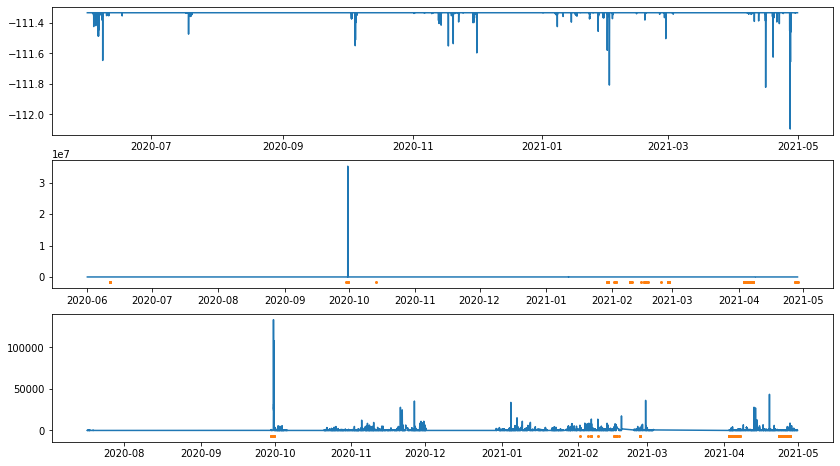

Validation signal range from -87.51964385504402 to 35292443.25425511


In [ ]:
#@title KDE - plot signal

kde.set_win_size(0)
min_signal, max_signal = kde.plot_sample_signal(
    train_data[0], val_data[0], test_data[0])

print(f"Validation signal range from {min_signal} to {max_signal}")

Best threshold: 1427.2727272727273
Cost on the training set: 0.0
Cost on the validation set: 2712.6
Cost on the test set: 6452.8
avg AUC ROC: 0.5131658809935541, avg AP: 0.027108935833527796


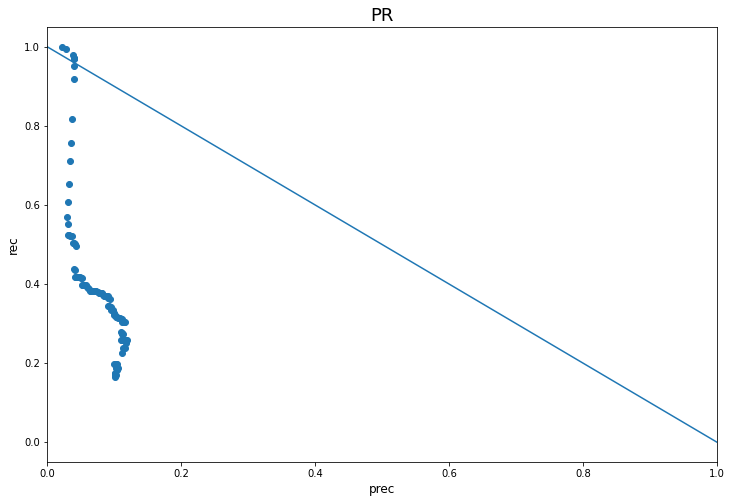

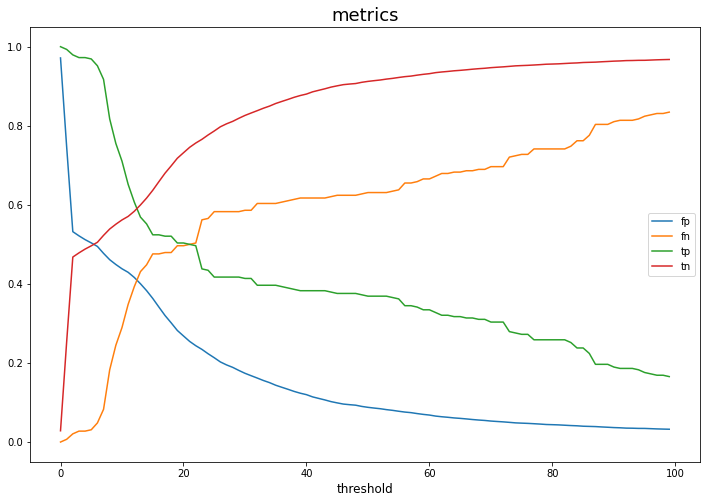

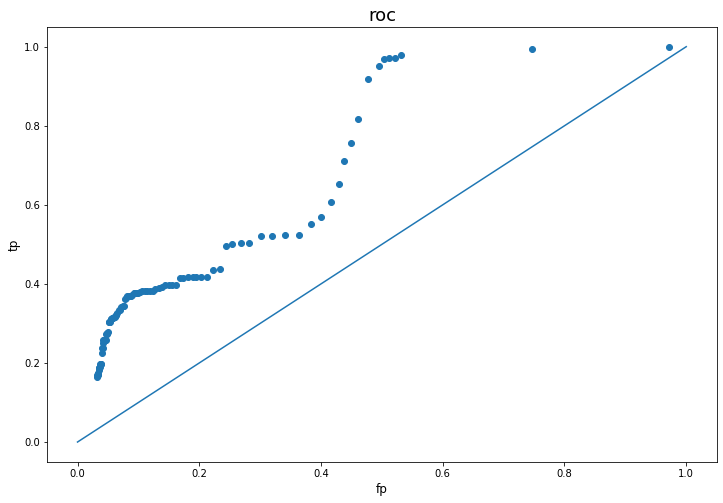

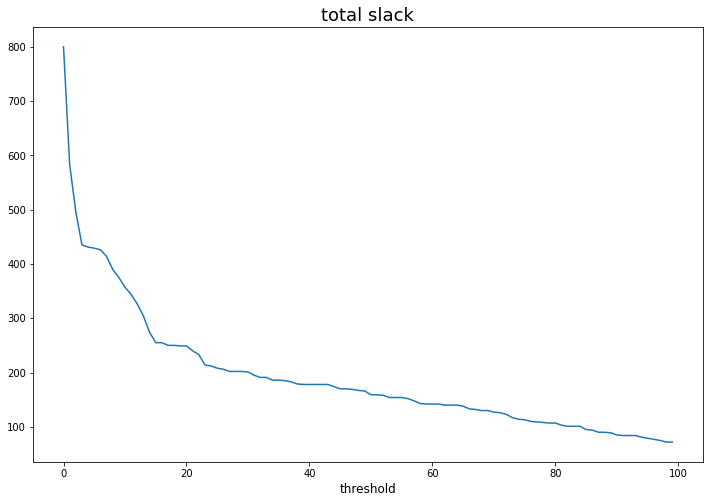

In [ ]:
#@title KDE - threshold search on sample

search_range = np.linspace(-1e2, 2e3, 100)

kde.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

## Autoencoder

In [ ]:
#@title AE - fit
 
ae = Autoencoder(batch_size, train_data, val_data, test_data)
ae.fit()

Epoch 1/200
2766/2766 [==============================] - 31s 10ms/step - loss: 0.1627 - val_loss: 0.0991
Epoch 2/200
2766/2766 [==============================] - 29s 11ms/step - loss: 0.1012 - val_loss: 0.0735
Epoch 3/200
2766/2766 [==============================] - 29s 11ms/step - loss: 0.0955 - val_loss: 0.0743
Epoch 4/200
2766/2766 [==============================] - 29s 11ms/step - loss: 0.0839 - val_loss: 0.1059
Epoch 5/200
2766/2766 [==============================] - 30s 11ms/step - loss: 0.1081 - val_loss: 0.0791
Epoch 6/200
2766/2766 [==============================] - 29s 11ms/step - loss: 0.0753 - val_loss: 0.0784
Epoch 7/200
2766/2766 [==============================] - 30s 11ms/step - loss: 0.0716 - val_loss: 0.0720
Epoch 8/200
2766/2766 [==============================] - 29s 11ms/step - loss: 0.0858 - val_loss: 0.0755
Epoch 9/200
2766/2766 [==============================] - 29s 11ms/step - loss: 0.0773 - val_loss: 0.0643
Epoch 10/200
2766/2766 [==============================]

KeyboardInterrupt: ignored

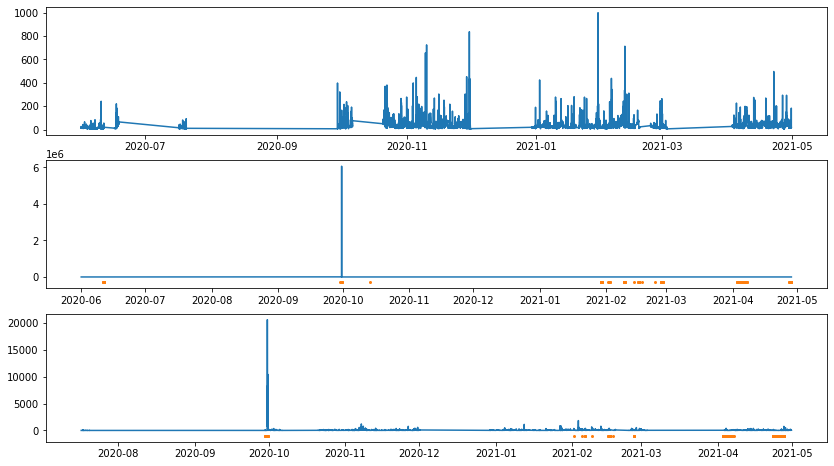

Validation signal range from 2.361447334289551 to 6059862.0


In [ ]:
#@title AE - plot signal

ae.set_win_size(0)
min_signal, max_signal = ae.plot_sample_signal(
    train_data[0], val_data[0], test_data[0])

print(f"Validation signal range from {min_signal} to {max_signal}")

In [ ]:
#@title AE - anomaly reconstruction error
ae.set_win_size(0)
ae.signal_analysis(pd.concat(test_data[:10]))

min:ps0_output_volta    0.452829
avg:ps0_output_volta    0.443821
max:ps0_output_volta    0.440429
var:p1_core8_temp       0.370518
var:p1_core0_temp       0.214266
var:dimm8_temp          0.201012
var:p1_core10_temp      0.195149
var:p0_core2_temp       0.190267
var:dimm7_temp          0.169810
var:dimm5_temp          0.169437
var:p1_core12_temp      0.166245
var:dimm11_temp         0.164551
var:p1_core5_temp       0.163307
var:p1_core6_temp       0.156726
min:ps1_input_voltag    0.154514
var:dimm2_temp          0.153168
var:dimm6_temp          0.152936
var:p1_core14_temp      0.145847
max:ps1_input_voltag    0.145704
var:p1_core11_temp      0.145685
dtype: float32


Best threshold: 100.0
Cost on the training set: 0.0
Cost on the validation set: 3150.2
Cost on the test set: 5976.4
avg AUC ROC: 0.4408736895577858, avg AP: 0.02097262818765706


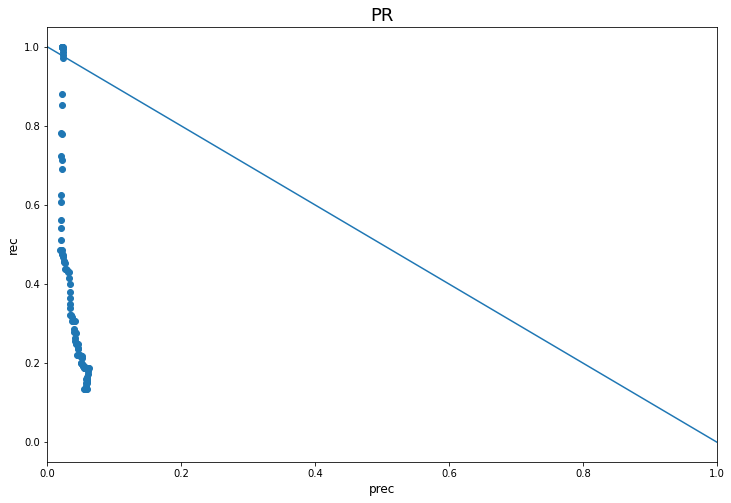

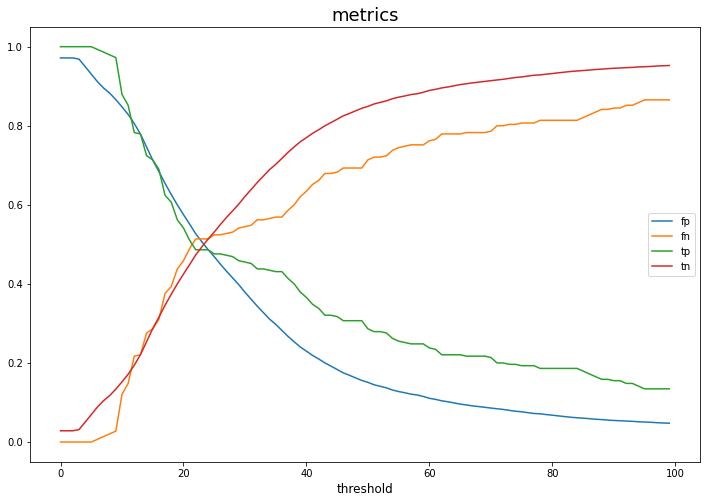

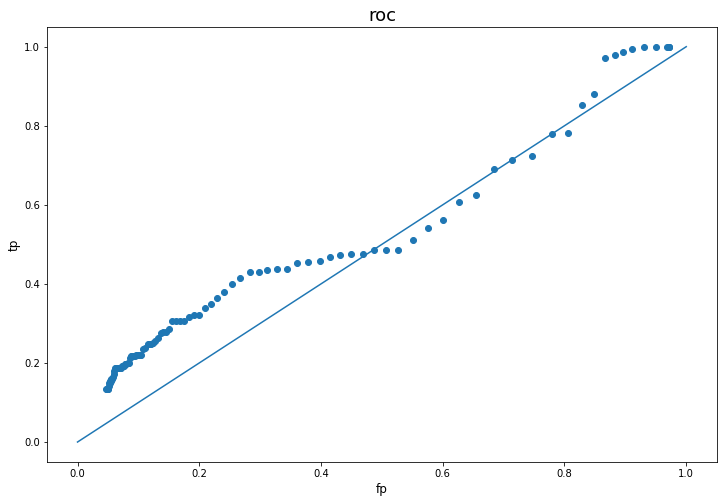

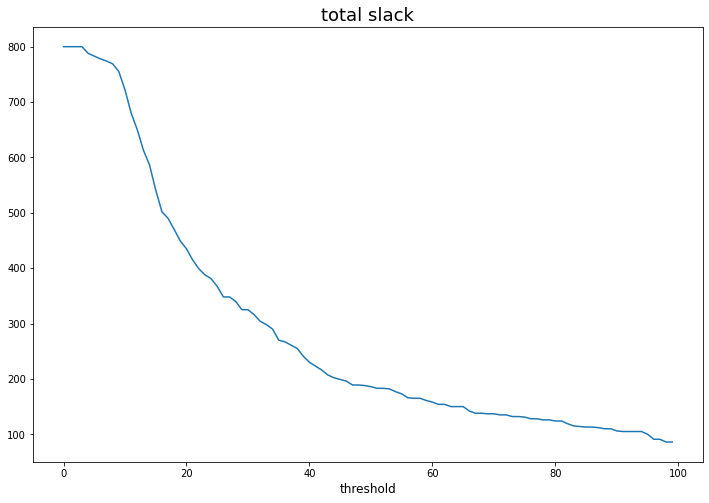

In [ ]:
#@title AE - threshold search on sample
 
search_range = np.linspace(0, 100, 100)
ae.set_win_size(0)
 
ae.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

In [ ]:
#@title AE - window and threshold optimization

ae.global_win_search(search_range)

## Real NVP

In [ ]:
#@title NVP - fit

nvp = NVP(batch_size, train_data, val_data, test_data)
nvp.fit()

Epoch 1/200
2766/2766 [==============================] - 56s 19ms/step - loss: 2271.4761 - val_loss: -4.6809


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/200
2766/2766 [==============================] - 50s 18ms/step - loss: -64.0805 - val_loss: -159.7394
Epoch 3/200
2766/2766 [==============================] - 52s 19ms/step - loss: -218.7832 - val_loss: -278.1419
Epoch 4/200
2766/2766 [==============================] - 54s 19ms/step - loss: -304.9670 - val_loss: -359.8293
Epoch 5/200
2766/2766 [==============================] - 52s 19ms/step - loss: -360.8850 - val_loss: -403.1174
Epoch 6/200
2766/2766 [==============================] - 52s 19ms/step - loss: -411.6792 - val_loss: -439.4192
Epoch 7/200
2766/2766 [==============================] - 51s 18ms/step - loss: -434.9529 - val_loss: -447.0598
Epoch 8/200
2766/2766 [==============================] - 51s 18ms/step - loss: -461.2166 - val_loss: -458.9268
Epoch 9/200
2766/2766 [==============================] - 50s 18ms/step - loss: -460.3449 - val_loss: -511.6525
Epoch 10/200
2766/2766 [==============================] - 52s 19ms/step - loss: -497.3874 - val_loss: -505.0883
E

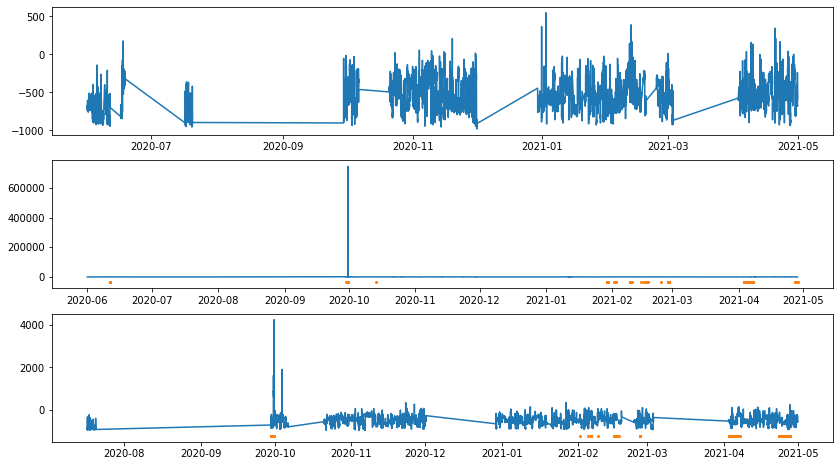

Validation signal range from -972.0938110351562 to 746097.375


In [ ]:
#@title NVP - plot signal

nvp.set_win_size(0)
min_signal, max_signal = nvp.plot_sample_signal(
    train_data[0], val_data[0], test_data[0])

print(f"Validation signal range from {min_signal} to {max_signal}")

Best threshold: 30.303030303030255
Cost on the training set: 0.0
Cost on the validation set: 2873.8
Cost on the test set: 5852.2
avg AUC ROC: 0.367020153765572, avg AP: 0.01805913947450886


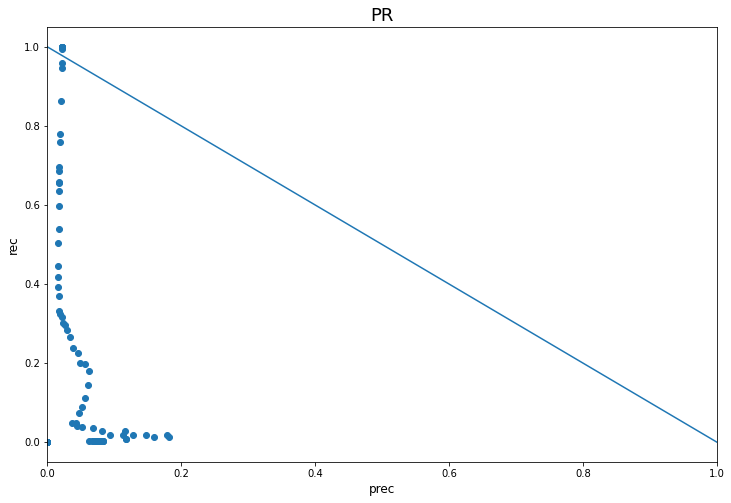

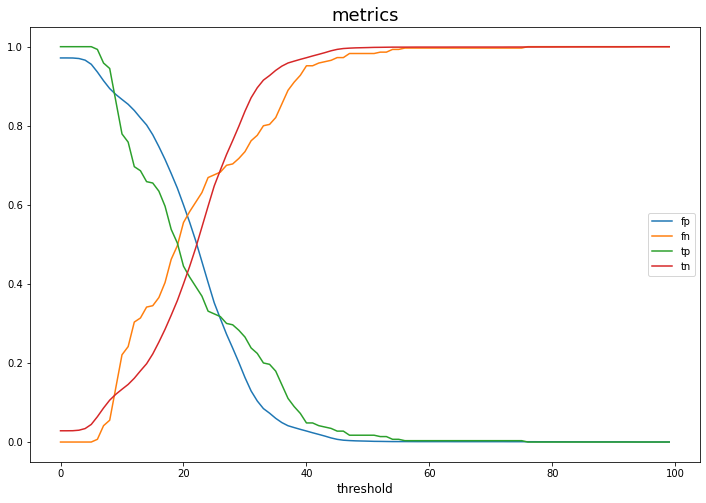

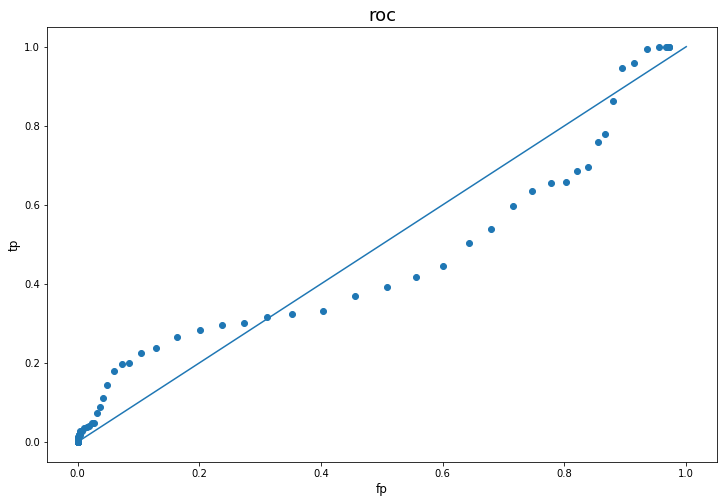

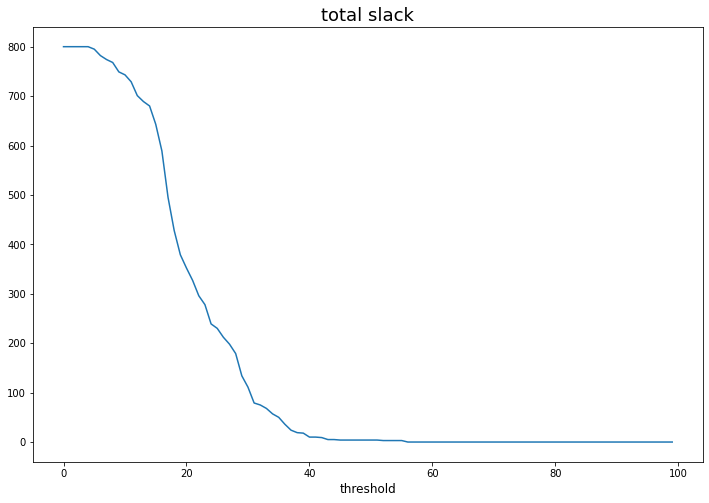

In [ ]:
#@title NVP - threshold search on sample
 
search_range = np.linspace(-1e3, 1e3, 100)
 
nvp.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

100%|██████████| 13/13 [1:54:05<00:00, 526.57s/it]


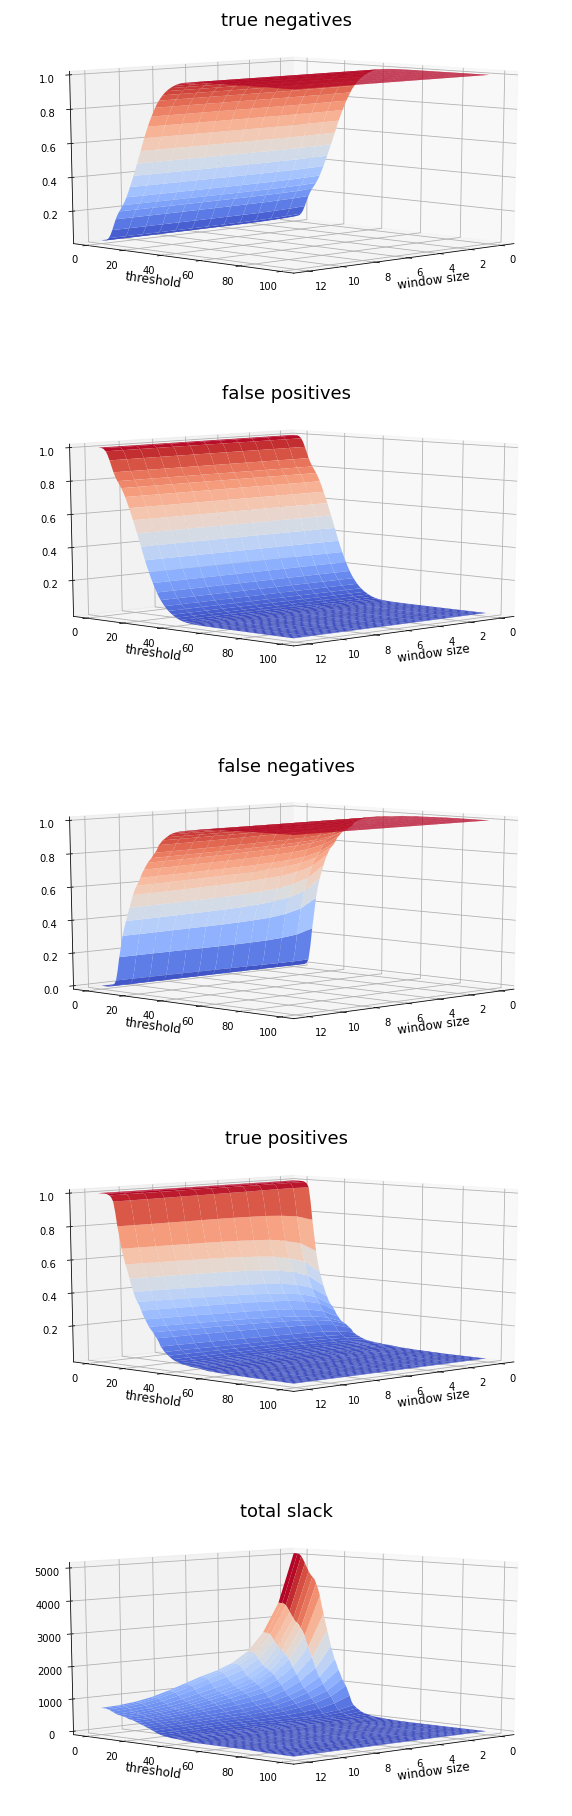

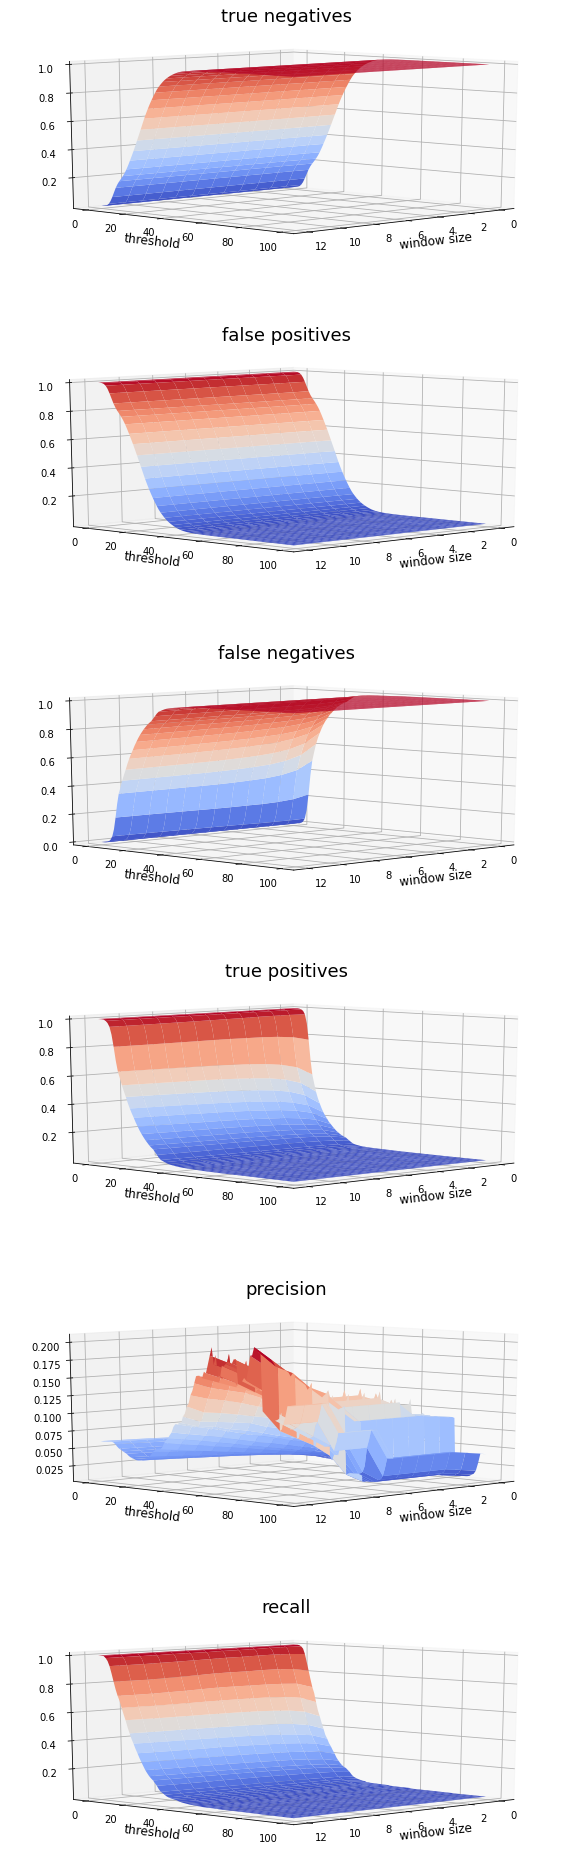

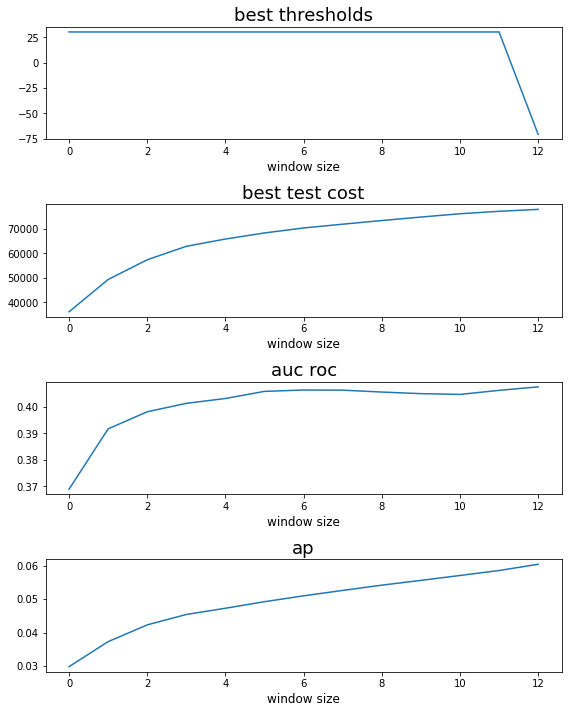

In [ ]:
#@title NVP - window and threshold optimization
 
nvp.global_win_search(search_range)

## MLP

In [ ]:
#@title MLP - fit

mlp = MLP(batch_size, train_data, val_data, test_data)
mlp.set_win_size(0)
mlp.fit()

Class weights for win_size=0: {0: 1.0411935290824235, 1: 25.275657421803167}
Epoch 1/200
2952/2952 [==============================] - 138s 46ms/step - loss: 0.9189 - auc_2: 0.8316 - val_loss: 0.4096 - val_auc_2: 0.9050
Epoch 2/200
2952/2952 [==============================] - 137s 46ms/step - loss: 0.7632 - auc_2: 0.8873 - val_loss: 0.4594 - val_auc_2: 0.8840
Epoch 3/200
2952/2952 [==============================] - 136s 46ms/step - loss: 0.6631 - auc_2: 0.9148 - val_loss: 0.3534 - val_auc_2: 0.9452
Epoch 4/200
2952/2952 [==============================] - 134s 46ms/step - loss: 0.5925 - auc_2: 0.9313 - val_loss: 0.3129 - val_auc_2: 0.8803
Epoch 5/200
2952/2952 [==============================] - 136s 46ms/step - loss: 0.5097 - auc_2: 0.9450 - val_loss: 0.2603 - val_auc_2: 0.9201
Epoch 6/200
2952/2952 [==============================] - 139s 47ms/step - loss: 0.5226 - auc_2: 0.9445 - val_loss: 0.4150 - val_auc_2: 0.8232
Epoch 7/200
2952/2952 [==============================] - 136s 46ms/step

Best threshold: 0.29292929292929293
Cost on the training set: 619.8
Cost on the validation set: 1630.4
Cost on the test set: 4919.0
avg AUC ROC: 0.8907328737737841, avg AP: 0.13869475574279197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


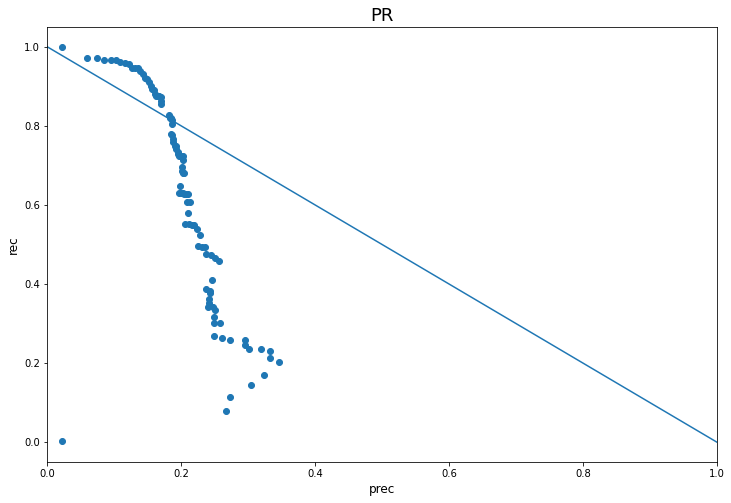

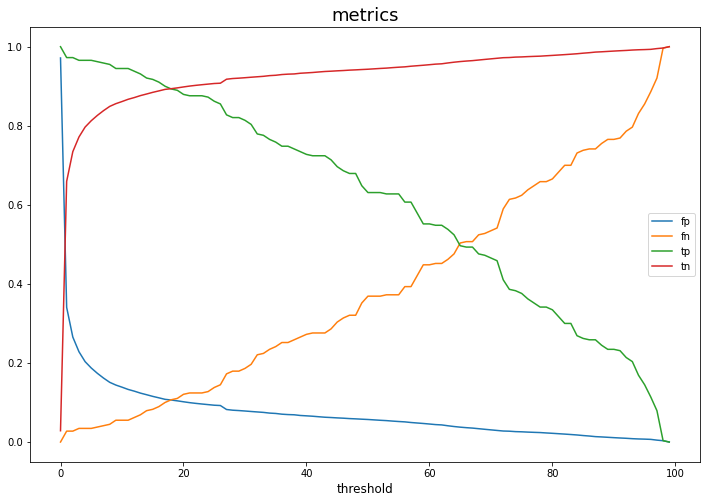

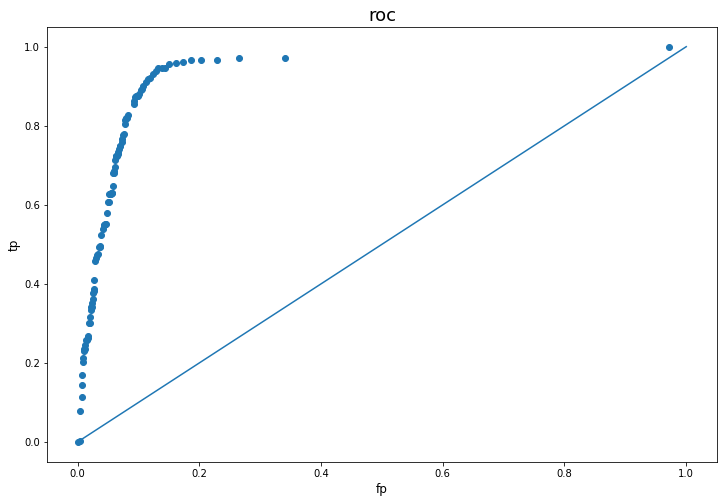

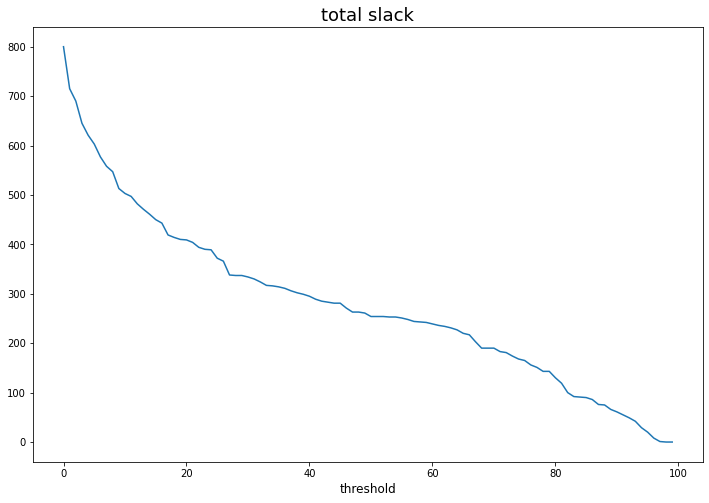

In [ ]:
#@title MLP - threshold search on sample

search_range = np.linspace(0, 1, 100)

mlp.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

  0%|          | 0/13 [00:00<?, ?it/s]

Class weights for win_size=0: {0: 1.0411935290824235, 1: 25.275657421803167}
Epoch 1/3
2952/2952 [==============================] - 135s 46ms/step - loss: 0.9197 - auc_3: 0.8380 - val_loss: 0.7254 - val_auc_3: 0.8305
Epoch 2/3
2952/2952 [==============================] - 135s 46ms/step - loss: 0.7902 - auc_3: 0.8793 - val_loss: 0.3318 - val_auc_3: 0.9026
Epoch 3/3
2952/2952 [==============================] - 135s 46ms/step - loss: 0.6668 - auc_3: 0.9120 - val_loss: 0.3109 - val_auc_3: 0.8989


  8%|▊         | 1/13 [21:26<4:17:19, 1286.64s/it]

Class weights for win_size=1: {0: 1.049319430448096, 1: 21.275984351692887}
Epoch 1/3
2952/2952 [==============================] - 138s 46ms/step - loss: 0.8794 - auc_4: 0.8487 - val_loss: 0.3402 - val_auc_4: 0.9084
Epoch 2/3
2952/2952 [==============================] - 138s 47ms/step - loss: 0.7543 - auc_4: 0.8911 - val_loss: 0.3759 - val_auc_4: 0.9040
Epoch 3/3
2952/2952 [==============================] - 138s 47ms/step - loss: 0.7276 - auc_4: 0.9037 - val_loss: 0.4054 - val_auc_4: 0.9042


 15%|█▌        | 2/13 [44:38<4:07:12, 1348.44s/it]

Class weights for win_size=2: {0: 1.0543700965863523, 1: 19.392463188138116}
Epoch 1/3
2952/2952 [==============================] - 140s 47ms/step - loss: 0.8703 - auc_5: 0.8585 - val_loss: 0.3649 - val_auc_5: 0.9093
Epoch 2/3
2952/2952 [==============================] - 142s 48ms/step - loss: 0.7299 - auc_5: 0.9000 - val_loss: 0.3254 - val_auc_5: 0.8831
Epoch 3/3
2952/2952 [==============================] - 140s 47ms/step - loss: 0.6900 - auc_5: 0.9119 - val_loss: 0.2215 - val_auc_5: 0.9248


 23%|██▎       | 3/13 [1:07:44<3:47:37, 1365.73s/it]

Class weights for win_size=3: {0: 1.0578173440137917, 1: 18.295848106780255}
Epoch 1/3
2952/2952 [==============================] - 146s 49ms/step - loss: 0.8679 - auc_6: 0.8620 - val_loss: 0.3147 - val_auc_6: 0.9117
Epoch 2/3
2952/2952 [==============================] - 144s 49ms/step - loss: 0.7203 - auc_6: 0.9051 - val_loss: 0.5020 - val_auc_6: 0.9011
Epoch 3/3
2952/2952 [==============================] - 141s 48ms/step - loss: 0.6198 - auc_6: 0.9288 - val_loss: 0.3541 - val_auc_6: 0.9124


 31%|███       | 4/13 [1:31:32<3:28:32, 1390.22s/it]

Class weights for win_size=4: {0: 1.0597503276861502, 1: 17.736309886912863}
Epoch 1/3
2952/2952 [==============================] - 144s 48ms/step - loss: 0.8665 - auc_7: 0.8637 - val_loss: 0.4170 - val_auc_7: 0.8964
Epoch 2/3
2952/2952 [==============================] - 145s 49ms/step - loss: 0.7156 - auc_7: 0.9065 - val_loss: 0.2839 - val_auc_7: 0.9579
Epoch 3/3
2952/2952 [==============================] - 145s 49ms/step - loss: 0.6453 - auc_7: 0.9231 - val_loss: 0.2973 - val_auc_7: 0.9273


 38%|███▊      | 5/13 [1:56:11<3:09:39, 1422.44s/it]

Class weights for win_size=5: {0: 1.0613516506466225, 1: 17.299479956291155}
Epoch 1/3
2952/2952 [==============================] - 145s 49ms/step - loss: 0.8770 - auc_8: 0.8600 - val_loss: 0.3283 - val_auc_8: 0.8978
Epoch 2/3
2952/2952 [==============================] - 147s 50ms/step - loss: 0.6974 - auc_8: 0.9122 - val_loss: 0.3474 - val_auc_8: 0.9061
Epoch 3/3
2952/2952 [==============================] - 146s 49ms/step - loss: 0.6015 - auc_8: 0.9321 - val_loss: 0.2940 - val_auc_8: 0.9111


 46%|████▌     | 6/13 [2:20:33<2:47:30, 1435.85s/it]

Class weights for win_size=6: {0: 1.0626373178408117, 1: 16.9649236983842}
Epoch 1/3
2952/2952 [==============================] - 148s 50ms/step - loss: 0.8595 - auc_9: 0.8661 - val_loss: 0.3265 - val_auc_9: 0.9014
Epoch 2/3
2952/2952 [==============================] - 150s 51ms/step - loss: 0.7516 - auc_9: 0.8971 - val_loss: 0.5615 - val_auc_9: 0.8805
Epoch 3/3
2952/2952 [==============================] - 148s 50ms/step - loss: 0.6534 - auc_9: 0.9218 - val_loss: 0.2783 - val_auc_9: 0.9218


 54%|█████▍    | 7/13 [2:44:38<2:23:52, 1438.81s/it]

Class weights for win_size=7: {0: 1.063622226607334, 1: 16.71777747062889}
Epoch 1/3
2952/2952 [==============================] - 151s 51ms/step - loss: 0.8572 - auc_10: 0.8642 - val_loss: 0.4066 - val_auc_10: 0.8949
Epoch 2/3
2952/2952 [==============================] - 150s 51ms/step - loss: 0.7309 - auc_10: 0.9036 - val_loss: 0.3498 - val_auc_10: 0.9109
Epoch 3/3
2952/2952 [==============================] - 150s 51ms/step - loss: 0.6404 - auc_10: 0.9251 - val_loss: 0.3092 - val_auc_10: 0.9435


 62%|██████▏   | 8/13 [3:09:51<2:01:51, 1462.38s/it]

Class weights for win_size=8: {0: 1.0645654854152569, 1: 16.488151193605024}
Epoch 1/3
2952/2952 [==============================] - 151s 51ms/step - loss: 0.9357 - auc_11: 0.8441 - val_loss: 0.4486 - val_auc_11: 0.9064
Epoch 2/3
2952/2952 [==============================] - 153s 52ms/step - loss: 0.7357 - auc_11: 0.9012 - val_loss: 0.3061 - val_auc_11: 0.9220
Epoch 3/3
2952/2952 [==============================] - 152s 51ms/step - loss: 0.6642 - auc_11: 0.9179 - val_loss: 0.4556 - val_auc_11: 0.9194


 69%|██████▉   | 9/13 [3:35:39<1:39:16, 1489.16s/it]

Class weights for win_size=9: {0: 1.0654582330004996, 1: 16.276917114343235}
Epoch 1/3
2952/2952 [==============================] - 153s 52ms/step - loss: 0.8694 - auc_12: 0.8615 - val_loss: 0.4329 - val_auc_12: 0.8821
Epoch 2/3
2952/2952 [==============================] - 156s 53ms/step - loss: 0.7490 - auc_12: 0.8991 - val_loss: 0.4112 - val_auc_12: 0.9111
Epoch 3/3
2952/2952 [==============================] - 156s 53ms/step - loss: 0.6596 - auc_12: 0.9214 - val_loss: 0.2584 - val_auc_12: 0.9242


 77%|███████▋  | 10/13 [4:01:29<1:15:23, 1507.85s/it]

Class weights for win_size=10: {0: 1.0662911866937346, 1: 16.084961514115037}
Epoch 1/3
2952/2952 [==============================] - 160s 54ms/step - loss: 0.8676 - auc_13: 0.8651 - val_loss: 0.3680 - val_auc_13: 0.9120
Epoch 2/3
2952/2952 [==============================] - 156s 53ms/step - loss: 0.7455 - auc_13: 0.9019 - val_loss: 0.4490 - val_auc_13: 0.8884
Epoch 3/3
2952/2952 [==============================] - 156s 53ms/step - loss: 0.6207 - auc_13: 0.9296 - val_loss: 0.2767 - val_auc_13: 0.9055


 85%|████████▍ | 11/13 [4:27:03<50:31, 1515.86s/it]  

Class weights for win_size=11: {0: 1.0669458384804755, 1: 15.937448282041416}
Epoch 1/3
2952/2952 [==============================] - 158s 53ms/step - loss: 0.9246 - auc_14: 0.8486 - val_loss: 0.5346 - val_auc_14: 0.8876
Epoch 2/3
2952/2952 [==============================] - 165s 56ms/step - loss: 0.7602 - auc_14: 0.8982 - val_loss: 0.3627 - val_auc_14: 0.8943
Epoch 3/3
2952/2952 [==============================] - 158s 53ms/step - loss: 0.6536 - auc_14: 0.9227 - val_loss: 0.2674 - val_auc_14: 0.9168


 92%|█████████▏| 12/13 [4:52:39<25:21, 1521.97s/it]

Class weights for win_size=12: {0: 1.0674772989311205, 1: 15.819798892969624}
Epoch 1/3
2952/2952 [==============================] - 160s 54ms/step - loss: 0.8779 - auc_15: 0.8596 - val_loss: 0.3795 - val_auc_15: 0.9037
Epoch 2/3
2952/2952 [==============================] - 162s 55ms/step - loss: 0.7590 - auc_15: 0.8980 - val_loss: 0.2856 - val_auc_15: 0.9388
Epoch 3/3
2952/2952 [==============================] - 162s 55ms/step - loss: 0.6500 - auc_15: 0.9232 - val_loss: 0.2011 - val_auc_15: 0.9178


100%|██████████| 13/13 [5:17:42<00:00, 1466.34s/it]


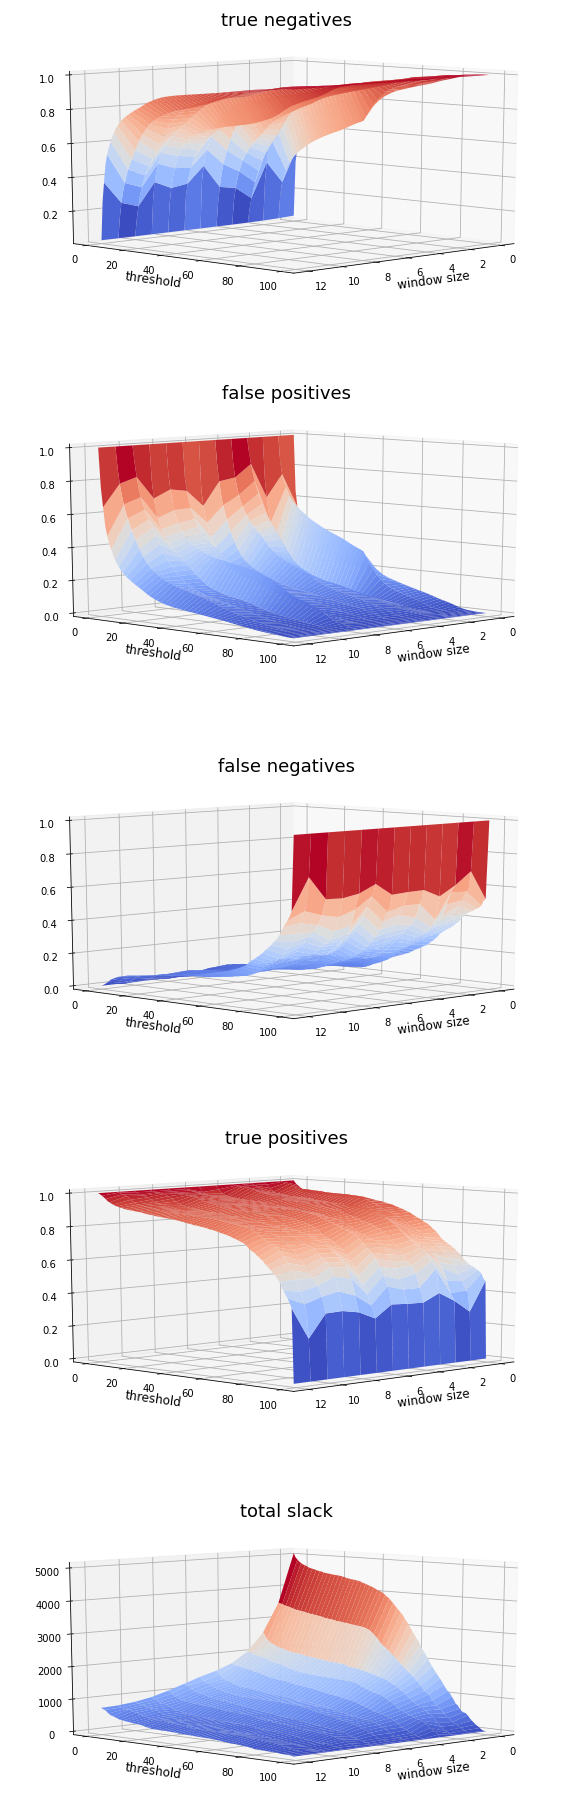

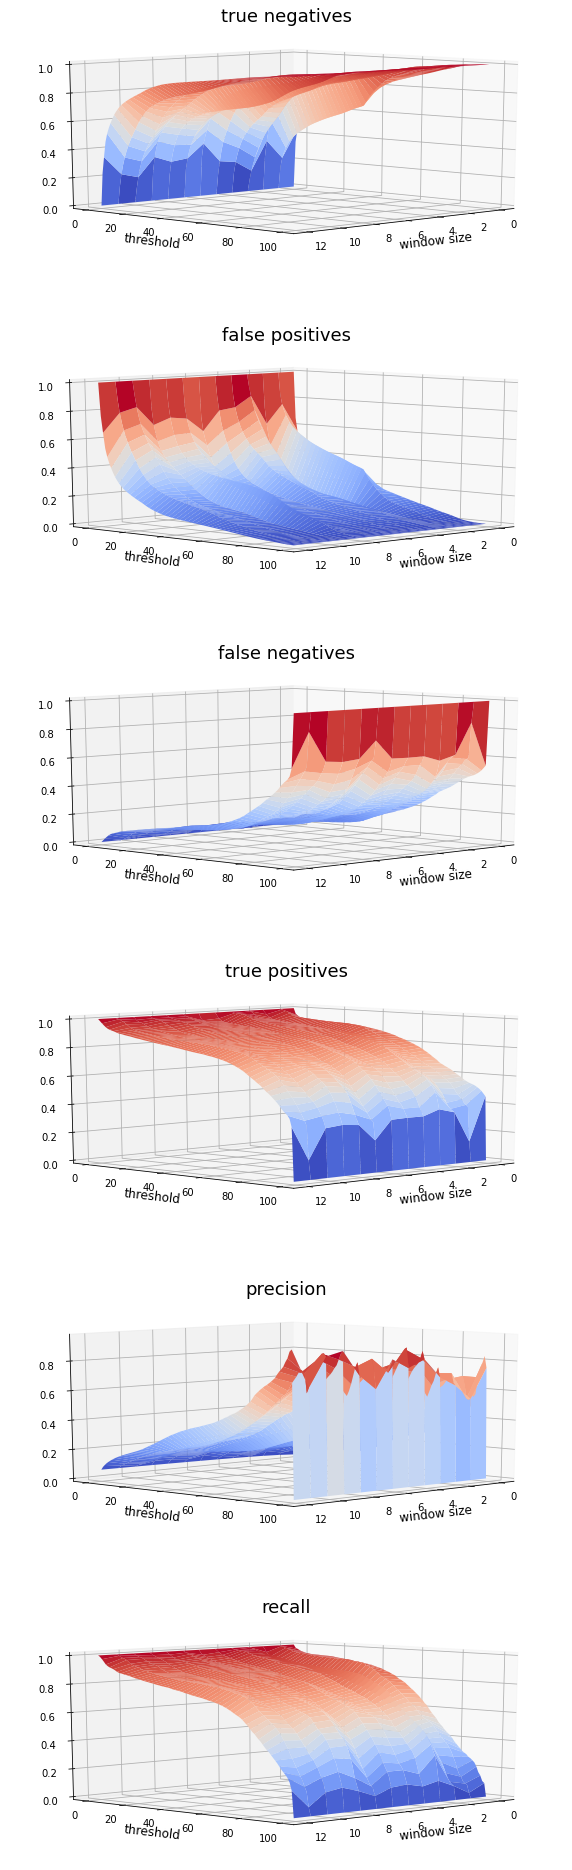

[[7.07070707e-01 2.22062000e+04 9.06620812e-01 3.72499210e-01]
 [7.97979798e-01 3.06538000e+04 9.15997019e-01 4.64315490e-01]
 [5.85858586e-01 2.67614000e+04 9.21281877e-01 5.08872012e-01]
 [6.96969697e-01 2.71062000e+04 9.25123826e-01 5.39422684e-01]
 [7.47474747e-01 3.05924000e+04 9.23134969e-01 5.72309374e-01]
 [6.46464646e-01 2.80928000e+04 9.16821032e-01 5.78828210e-01]
 [6.56565657e-01 2.67392000e+04 9.22596046e-01 5.96658539e-01]
 [6.76767677e-01 2.77638000e+04 9.14827762e-01 5.62090830e-01]
 [8.58585859e-01 3.72962000e+04 9.05389628e-01 5.49240466e-01]
 [6.66666667e-01 3.13272000e+04 9.17911922e-01 6.31560860e-01]
 [7.07070707e-01 3.08626000e+04 9.15805232e-01 6.28645002e-01]
 [6.86868687e-01 3.17200000e+04 9.18514552e-01 5.78244315e-01]
 [5.65656566e-01 2.96972000e+04 9.15935511e-01 6.16881666e-01]]


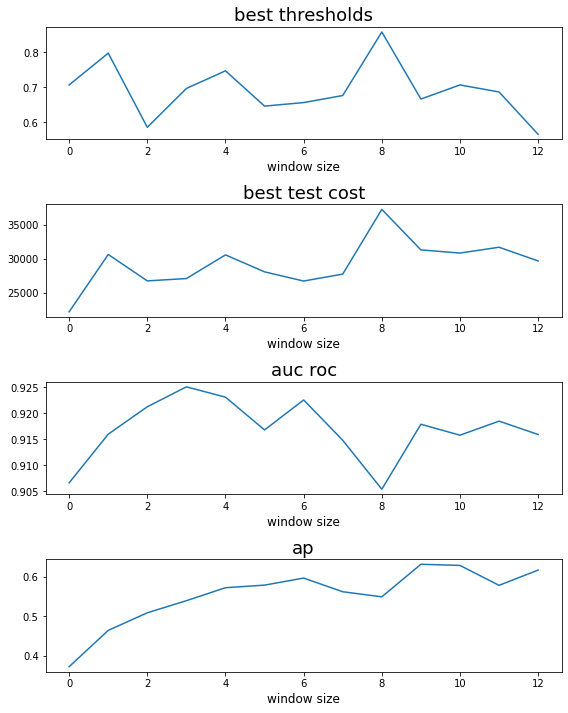

In [ ]:
#@title MLP - window and threshold optimization

mlp.global_win_search(search_range)

## Transformer encoder

In [ ]:
#@title Transformer - fit

transformer = Transformer(batch_size, train_data, val_data, test_data)
transformer.set_win_size(0)
transformer.fit(10)

Class weights for win_size=0: {0: 1.0411935290824235, 1: 25.275657421803167}
Epoch 1/10
2952/2952 [==============================] - 209s 69ms/step - loss: 1.1253 - auc: 0.7851 - val_loss: 0.4989 - val_auc: 0.8987


wandb: ERROR Can't save model, h5py returned error: Layer Encoder has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/10
2952/2952 [==============================] - 204s 69ms/step - loss: 0.8588 - auc: 0.8554 - val_loss: 0.3139 - val_auc: 0.8963
Epoch 3/10
2952/2952 [==============================] - 205s 69ms/step - loss: 0.7946 - auc: 0.8805 - val_loss: 0.5197 - val_auc: 0.8662
Epoch 4/10
2952/2952 [==============================] - 204s 69ms/step - loss: 0.7639 - auc: 0.8856 - val_loss: 0.3890 - val_auc: 0.9194
Epoch 5/10
2952/2952 [==============================] - 204s 69ms/step - loss: 0.6914 - auc: 0.9052 - val_loss: 0.3782 - val_auc: 0.9457
Epoch 6/10
2952/2952 [==============================] - 204s 69ms/step - loss: 0.6649 - auc: 0.9120 - val_loss: 0.3096 - val_auc: 0.9584
Epoch 7/10
2952/2952 [==============================] - 204s 69ms/step - loss: 0.6302 - auc: 0.9213 - val_loss: 0.2457 - val_auc: 0.9435
Epoch 8/10
2952/2952 [==============================] - 204s 69ms/step - loss: 0.6070 - auc: 0.9282 - val_loss: 0.2917 - val_auc: 0.9505
Epoch 9/10
2952/2952 [===================

Best threshold: 0.6767676767676768
Cost on the training set: 804.0
Cost on the validation set: 1412.6
Cost on the test set: 3762.0
avg AUC ROC: 0.9244801002292533, avg AP: 0.2798486268968159


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


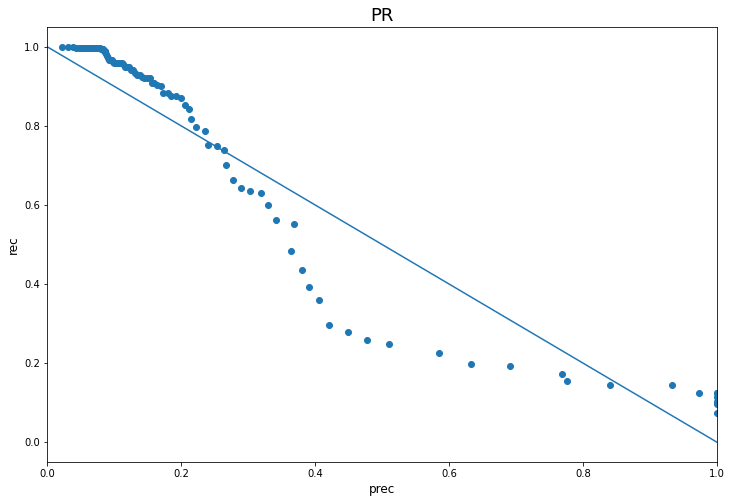

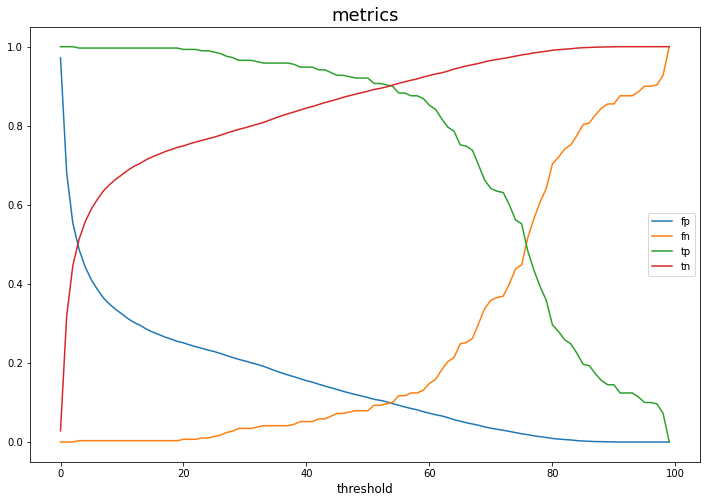

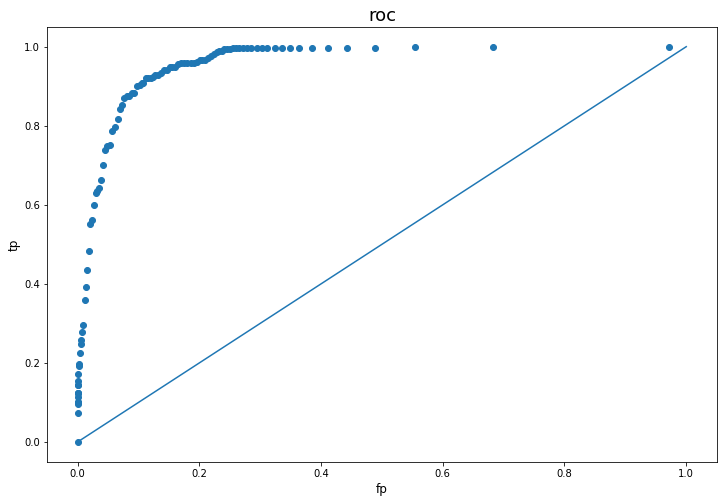

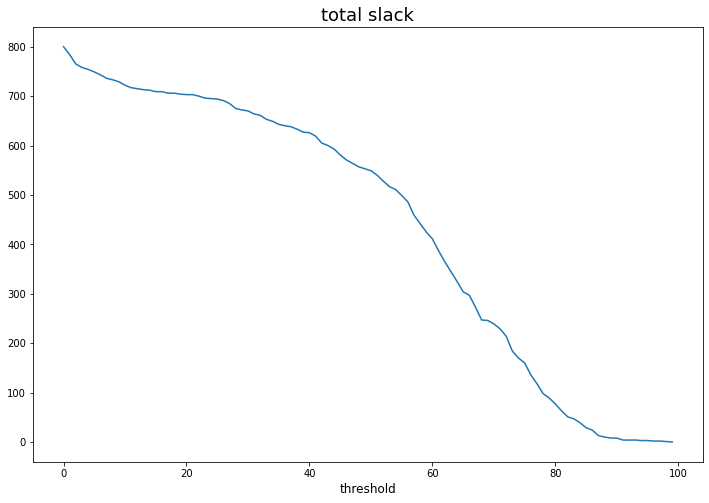

In [ ]:
#@title Transformer - threshold search on sample

search_range = np.linspace(0, 1, 100)

transformer.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

  0%|          | 0/13 [00:00<?, ?it/s]

Class weights for win_size=0: {0: 1.0411935290824235, 1: 25.275657421803167}
Epoch 1/3
2952/2952 [==============================] - 209s 70ms/step - loss: 1.0608 - auc_1: 0.8010 - val_loss: 0.2765 - val_auc_1: 0.8736
Epoch 2/3
2952/2952 [==============================] - 203s 69ms/step - loss: 0.8511 - auc_1: 0.8638 - val_loss: 0.5274 - val_auc_1: 0.9425
Epoch 3/3
2952/2952 [==============================] - 204s 69ms/step - loss: 0.8062 - auc_1: 0.8761 - val_loss: 0.3345 - val_auc_1: 0.9246


  8%|▊         | 1/13 [21:18<4:15:40, 1278.34s/it]

Class weights for win_size=1: {0: 1.049319430448096, 1: 21.275984351692887}
Epoch 1/3
2952/2952 [==============================] - 208s 70ms/step - loss: 0.9921 - auc_2: 0.8254 - val_loss: 0.4022 - val_auc_2: 0.9042
Epoch 2/3
2952/2952 [==============================] - 206s 70ms/step - loss: 0.8355 - auc_2: 0.8686 - val_loss: 0.3603 - val_auc_2: 0.9215
Epoch 3/3
2952/2952 [==============================] - 205s 69ms/step - loss: 0.7821 - auc_2: 0.8858 - val_loss: 0.3756 - val_auc_2: 0.8929


 15%|█▌        | 2/13 [42:34<3:54:05, 1276.85s/it]

Class weights for win_size=2: {0: 1.0543700965863523, 1: 19.392463188138116}
Epoch 1/3
2952/2952 [==============================] - 209s 70ms/step - loss: 0.9876 - auc_3: 0.8270 - val_loss: 0.2914 - val_auc_3: 0.8984
Epoch 2/3
2952/2952 [==============================] - 207s 70ms/step - loss: 0.8232 - auc_3: 0.8763 - val_loss: 0.5932 - val_auc_3: 0.9235
Epoch 3/3
2952/2952 [==============================] - 206s 70ms/step - loss: 0.7443 - auc_3: 0.8969 - val_loss: 0.3174 - val_auc_3: 0.9389


 23%|██▎       | 3/13 [1:04:20<3:35:03, 1290.39s/it]

Class weights for win_size=3: {0: 1.0578173440137917, 1: 18.295848106780255}
Epoch 1/3
2952/2952 [==============================] - 210s 70ms/step - loss: 0.9945 - auc_4: 0.8329 - val_loss: 0.4014 - val_auc_4: 0.9077
Epoch 2/3
2952/2952 [==============================] - 208s 70ms/step - loss: 0.8293 - auc_4: 0.8742 - val_loss: 0.4036 - val_auc_4: 0.9039
Epoch 3/3
2952/2952 [==============================] - 208s 70ms/step - loss: 0.7705 - auc_4: 0.8917 - val_loss: 0.2122 - val_auc_4: 0.9312


 31%|███       | 4/13 [1:25:13<3:11:20, 1275.64s/it]

Class weights for win_size=4: {0: 1.0597503276861502, 1: 17.736309886912863}
Epoch 1/3
2952/2952 [==============================] - 214s 72ms/step - loss: 0.9653 - auc_5: 0.8349 - val_loss: 0.3737 - val_auc_5: 0.9010
Epoch 2/3
2952/2952 [==============================] - 209s 71ms/step - loss: 0.8448 - auc_5: 0.8720 - val_loss: 0.3940 - val_auc_5: 0.9137
Epoch 3/3
2952/2952 [==============================] - 208s 70ms/step - loss: 0.7524 - auc_5: 0.8945 - val_loss: 0.2476 - val_auc_5: 0.8990


 38%|███▊      | 5/13 [1:45:35<2:47:29, 1256.13s/it]

Class weights for win_size=5: {0: 1.0613516506466225, 1: 17.299479956291155}
Epoch 1/3
2952/2952 [==============================] - 216s 73ms/step - loss: 0.9850 - auc_6: 0.8352 - val_loss: 0.3178 - val_auc_6: 0.8986
Epoch 2/3
2952/2952 [==============================] - 211s 71ms/step - loss: 0.8319 - auc_6: 0.8748 - val_loss: 0.3881 - val_auc_6: 0.9000
Epoch 3/3
2952/2952 [==============================] - 211s 71ms/step - loss: 0.7901 - auc_6: 0.8882 - val_loss: 0.3423 - val_auc_6: 0.9068


 46%|████▌     | 6/13 [2:08:49<2:32:01, 1303.08s/it]

Class weights for win_size=6: {0: 1.0626373178408117, 1: 16.9649236983842}
Epoch 1/3
2952/2952 [==============================] - 216s 72ms/step - loss: 1.0090 - auc_7: 0.8263 - val_loss: 0.3000 - val_auc_7: 0.8619
Epoch 2/3
2952/2952 [==============================] - 214s 73ms/step - loss: 0.8396 - auc_7: 0.8730 - val_loss: 0.6676 - val_auc_7: 0.8854
Epoch 3/3
2952/2952 [==============================] - 214s 72ms/step - loss: 0.7858 - auc_7: 0.8873 - val_loss: 0.3540 - val_auc_7: 0.9195


 54%|█████▍    | 7/13 [2:32:12<2:13:34, 1335.67s/it]

Class weights for win_size=7: {0: 1.063622226607334, 1: 16.71777747062889}
Epoch 1/3
2952/2952 [==============================] - 216s 72ms/step - loss: 0.9877 - auc_8: 0.8293 - val_loss: 0.3407 - val_auc_8: 0.9067
Epoch 2/3
2952/2952 [==============================] - 214s 72ms/step - loss: 0.8259 - auc_8: 0.8774 - val_loss: 0.3192 - val_auc_8: 0.8984
Epoch 3/3
2952/2952 [==============================] - 213s 72ms/step - loss: 0.7924 - auc_8: 0.8880 - val_loss: 0.8504 - val_auc_8: 0.8034


 62%|██████▏   | 8/13 [2:56:30<1:54:34, 1374.83s/it]

Class weights for win_size=8: {0: 1.0645654854152569, 1: 16.488151193605024}
Epoch 1/3
2952/2952 [==============================] - 218s 73ms/step - loss: 0.9807 - auc_9: 0.8353 - val_loss: 0.3645 - val_auc_9: 0.9057
Epoch 2/3
2952/2952 [==============================] - 214s 72ms/step - loss: 0.8334 - auc_9: 0.8756 - val_loss: 0.3524 - val_auc_9: 0.9229
Epoch 3/3
2952/2952 [==============================] - 214s 73ms/step - loss: 0.7719 - auc_9: 0.8923 - val_loss: 0.3972 - val_auc_9: 0.9010


 69%|██████▉   | 9/13 [3:19:35<1:31:51, 1377.85s/it]

Class weights for win_size=9: {0: 1.0654582330004996, 1: 16.276917114343235}
Epoch 1/3
2952/2952 [==============================] - 218s 73ms/step - loss: 0.9673 - auc_10: 0.8368 - val_loss: 0.4989 - val_auc_10: 0.8409
Epoch 2/3
2952/2952 [==============================] - 216s 73ms/step - loss: 0.8456 - auc_10: 0.8735 - val_loss: 0.4888 - val_auc_10: 0.8984
Epoch 3/3
2952/2952 [==============================] - 215s 73ms/step - loss: 0.7546 - auc_10: 0.8965 - val_loss: 0.3615 - val_auc_10: 0.9040


 77%|███████▋  | 10/13 [3:42:24<1:08:45, 1375.10s/it]

Class weights for win_size=10: {0: 1.0662911866937346, 1: 16.084961514115037}
Epoch 1/3
2952/2952 [==============================] - 221s 74ms/step - loss: 0.9838 - auc_11: 0.8364 - val_loss: 0.9188 - val_auc_11: 0.8129
Epoch 2/3
2952/2952 [==============================] - 218s 74ms/step - loss: 0.8293 - auc_11: 0.8761 - val_loss: 0.7725 - val_auc_11: 0.8688
Epoch 3/3
2952/2952 [==============================] - 218s 74ms/step - loss: 0.7781 - auc_11: 0.8906 - val_loss: 0.4663 - val_auc_11: 0.8834


 85%|████████▍ | 11/13 [4:06:12<46:22, 1391.31s/it]  

Class weights for win_size=11: {0: 1.0669458384804755, 1: 15.937448282041416}
Epoch 1/3
2952/2952 [==============================] - 223s 75ms/step - loss: 0.9994 - auc_12: 0.8300 - val_loss: 0.5172 - val_auc_12: 0.8404
Epoch 2/3
2952/2952 [==============================] - 220s 74ms/step - loss: 0.8566 - auc_12: 0.8680 - val_loss: 0.3438 - val_auc_12: 0.8717
Epoch 3/3
2952/2952 [==============================] - 220s 75ms/step - loss: 0.7801 - auc_12: 0.8913 - val_loss: 0.4300 - val_auc_12: 0.8678


 92%|█████████▏| 12/13 [4:29:18<23:09, 1389.88s/it]

Class weights for win_size=12: {0: 1.0674772989311205, 1: 15.819798892969624}
Epoch 1/3
2952/2952 [==============================] - 225s 75ms/step - loss: 0.9645 - auc_13: 0.8355 - val_loss: 0.2671 - val_auc_13: 0.8442
Epoch 2/3
2952/2952 [==============================] - 224s 76ms/step - loss: 0.8637 - auc_13: 0.8672 - val_loss: 0.4575 - val_auc_13: 0.8755
Epoch 3/3
2952/2952 [==============================] - 223s 76ms/step - loss: 0.7385 - auc_13: 0.8982 - val_loss: 0.3792 - val_auc_13: 0.9006


100%|██████████| 13/13 [4:52:32<00:00, 1350.23s/it]


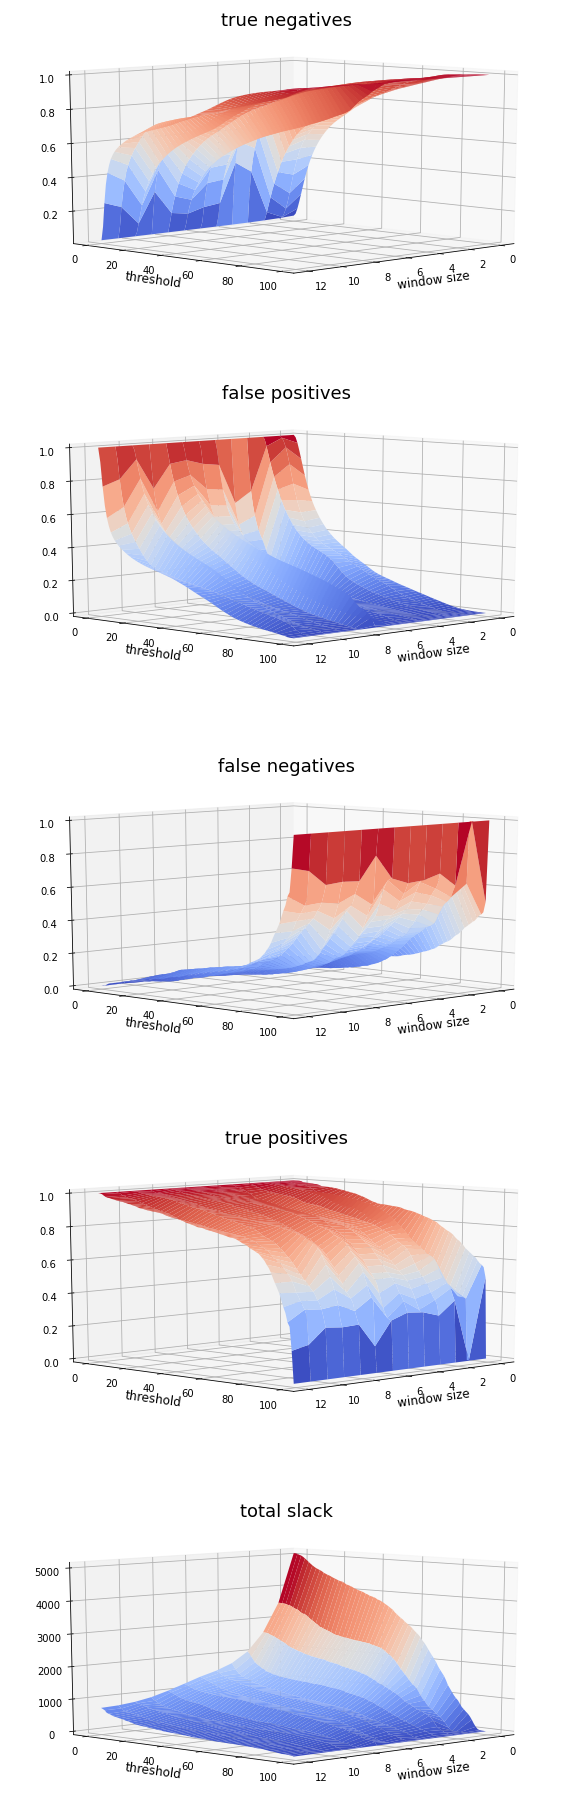

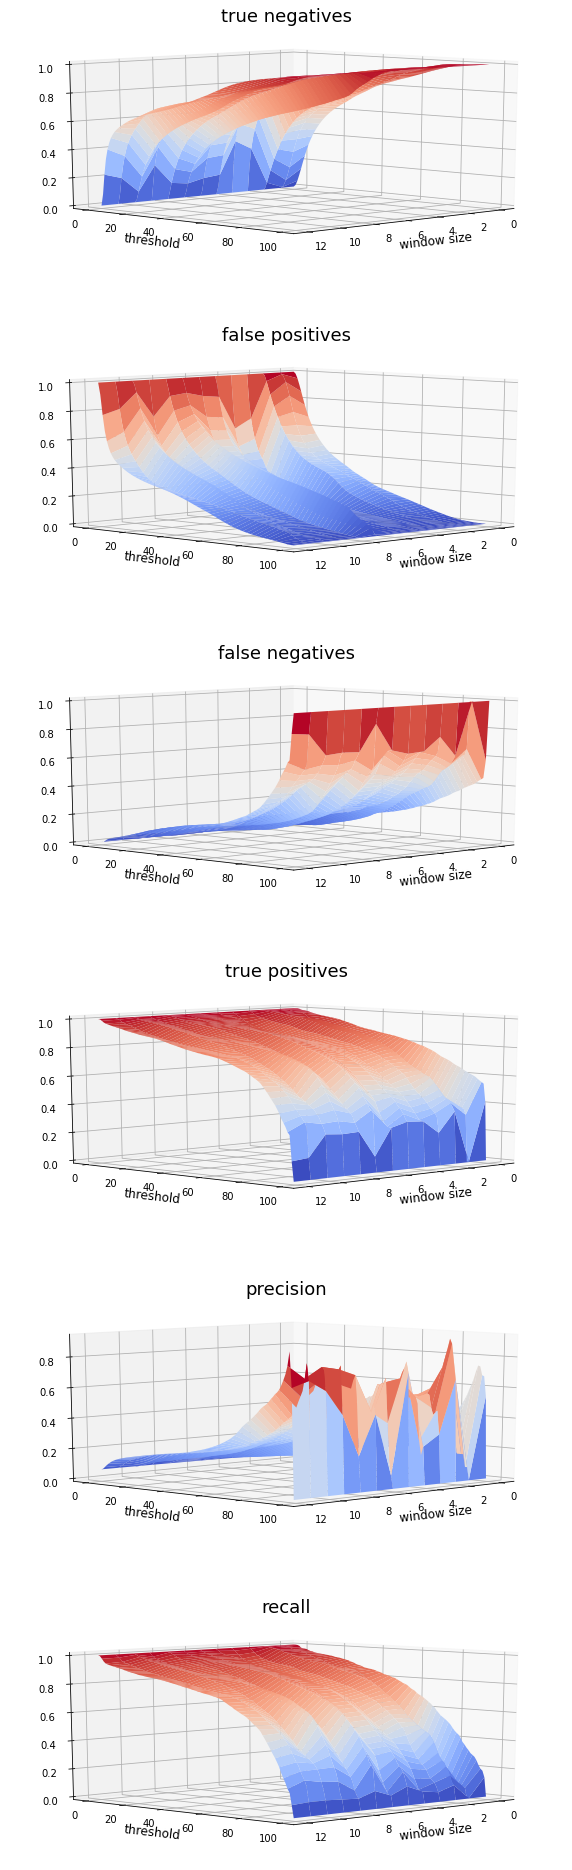

[[8.18181818e-01 2.51886000e+04 8.94881356e-01 4.15651765e-01]
 [6.36363636e-01 3.18560000e+04 8.77440046e-01 2.90264971e-01]
 [6.26262626e-01 2.89806000e+04 9.10059224e-01 4.96480078e-01]
 [6.56565657e-01 2.93588000e+04 9.17655962e-01 4.35619247e-01]
 [6.26262626e-01 2.97162000e+04 9.02485540e-01 4.37883092e-01]
 [6.96969697e-01 3.19216000e+04 8.97461877e-01 4.66738870e-01]
 [6.46464646e-01 3.10408000e+04 9.03125884e-01 4.83537772e-01]
 [8.98989899e-01 5.24422000e+04 8.27148176e-01 3.44622012e-01]
 [7.47474747e-01 3.50790000e+04 8.90802710e-01 4.26047337e-01]
 [7.47474747e-01 3.29150000e+04 9.04359352e-01 5.20438456e-01]
 [7.27272727e-01 4.54030000e+04 8.79100660e-01 4.56453840e-01]
 [7.27272727e-01 4.12802000e+04 8.77036967e-01 4.42732248e-01]
 [7.27272727e-01 3.58206000e+04 8.97078631e-01 5.04196770e-01]]


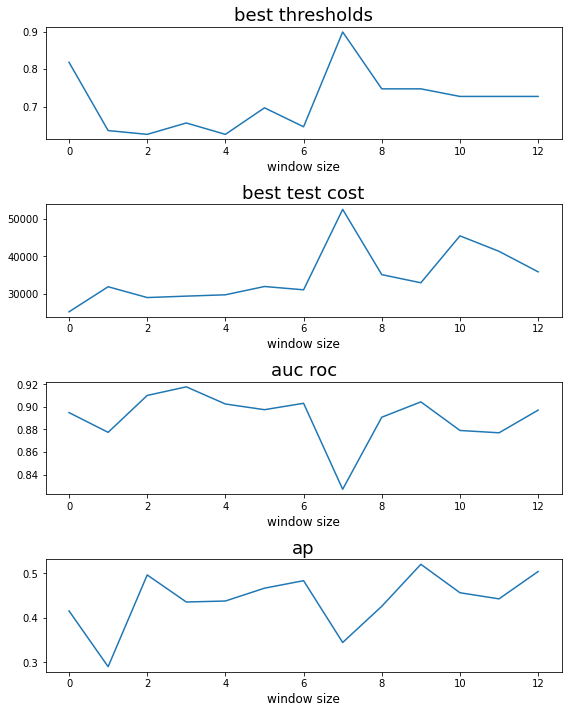

In [ ]:
#@title Transformer - window and threshold optimization

transformer.global_win_search(search_range)

## Random forest


In [ ]:
#@title Random forest - fit

rf = RandomForest(None, train_data, val_data, test_data)
rf.set_win_size(0)
rf.fit()

epoch 1


100%|██████████| 217/217 [00:32<00:00,  6.69it/s]


validating...


100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


epoch 2


100%|██████████| 217/217 [00:32<00:00,  6.73it/s]


validating...


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]

early stopping


Best threshold: 0.045454545454545456
Cost on the training set: 1513.0
Cost on the validation set: 2095.8
Cost on the test set: 4770.6
avg AUC ROC: 0.857016705752917, avg AP: 0.19260955620571912


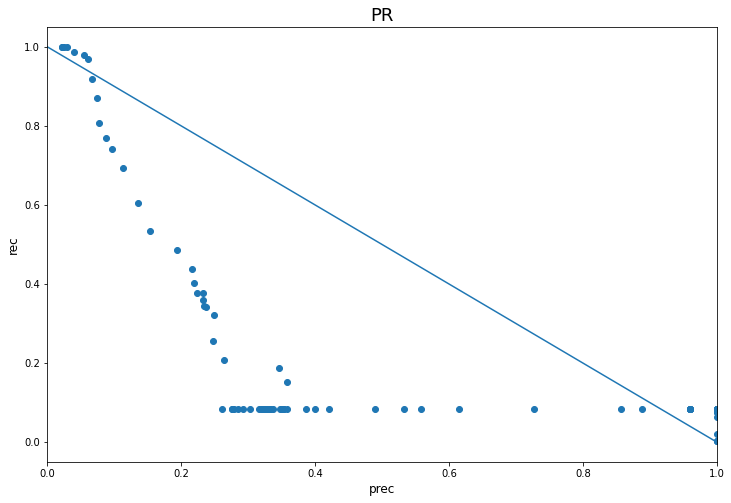

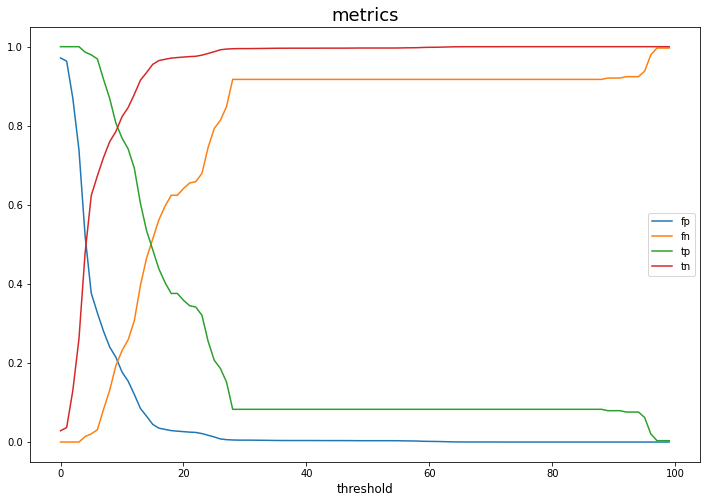

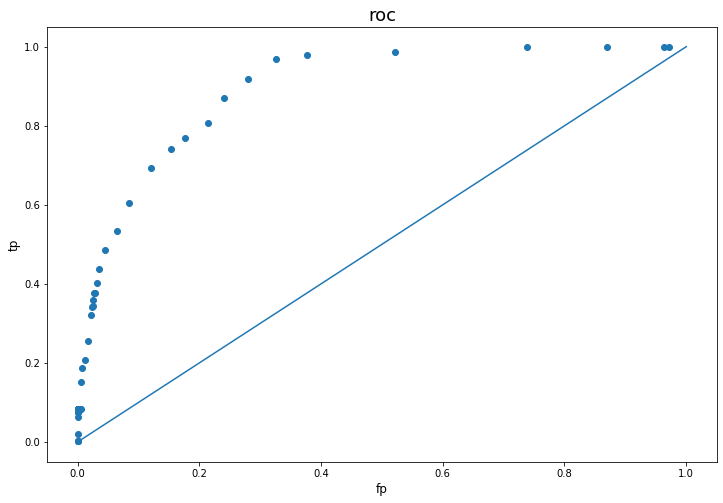

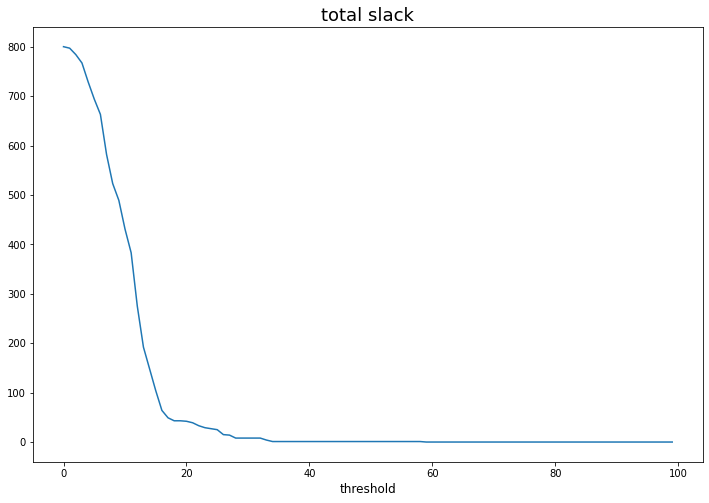

In [ ]:
#@title Random forest - threshold search on sample

search_range = np.linspace(0, 0.3, 100)

rf.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

Top 30 most important features:
Index(['max:proc_total', 'avg:proc_total', 'avg:cpu_aidle', 'min:cpu_aidle',
       'min:proc_total', 'max:cpu_aidle', 'max:mem_total', 'min:mem_free',
       'max:part_max_used', 'avg:mem_cached', 'min:boottime',
       'avg:part_max_used', 'avg:swap_free', 'max:swap_free', 'max:mem_cached',
       'max:mem_free', 'avg:mem_total', 'min:mem_cached', 'avg:boottime',
       'min:mem_total', 'min:swap_free', 'min:mem_buffers', 'avg:mem_free',
       'max:boottime', 'avg:mem_buffers', 'min:part_max_used',
       'max:mem_buffers', 'avg:load_five', 'max:load_fifteen',
       'min:load_five'],
      dtype='object')


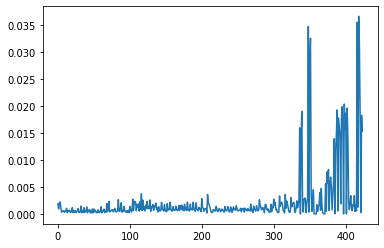

In [ ]:
#@title Random forest - feature importance

plt.plot(rf.model.feature_importances_)
print("Top 30 most important features:")
print(FEATURES[np.argsort(rf.model.feature_importances_)[::-1][:30]])

  0%|          | 0/13 [00:00<?, ?it/s]

epoch 1



100%|██████████| 217/217 [00:33<00:00,  6.45it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


epoch 2



100%|██████████| 217/217 [00:33<00:00,  6.51it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


early stopping


  8%|▊         | 1/13 [07:12<1:26:29, 432.42s/it]

epoch 1



100%|██████████| 217/217 [00:33<00:00,  6.42it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


epoch 2



100%|██████████| 217/217 [00:34<00:00,  6.29it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


early stopping


 15%|█▌        | 2/13 [15:29<1:26:16, 470.61s/it]

epoch 1



100%|██████████| 217/217 [00:35<00:00,  6.10it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


epoch 2



100%|██████████| 217/217 [00:35<00:00,  6.08it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


early stopping


 23%|██▎       | 3/13 [24:31<1:23:50, 503.06s/it]

epoch 1



100%|██████████| 217/217 [00:35<00:00,  6.07it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


epoch 2



100%|██████████| 217/217 [00:36<00:00,  5.97it/s]


validating...



100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


epoch 3



100%|██████████| 217/217 [00:36<00:00,  5.98it/s]


validating...



 31%|███       | 4/13 [35:02<1:23:03, 553.75s/it]

epoch 1



100%|██████████| 217/217 [00:36<00:00,  5.95it/s]


validating...



100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


epoch 2



100%|██████████| 217/217 [00:36<00:00,  5.94it/s]


validating...



100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


early stopping


 38%|███▊      | 5/13 [45:00<1:15:57, 569.68s/it]

epoch 1



100%|██████████| 217/217 [00:36<00:00,  5.95it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


epoch 2



100%|██████████| 217/217 [00:36<00:00,  5.92it/s]


validating...



100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


epoch 3



100%|██████████| 217/217 [00:37<00:00,  5.86it/s]


validating...



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


early stopping


 46%|████▌     | 6/13 [56:15<1:10:37, 605.39s/it]

epoch 1



100%|██████████| 217/217 [00:36<00:00,  5.91it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


epoch 2



100%|██████████| 217/217 [00:37<00:00,  5.81it/s]


validating...



100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


early stopping


 54%|█████▍    | 7/13 [1:06:49<1:01:29, 614.86s/it]

epoch 1



100%|██████████| 217/217 [00:36<00:00,  5.98it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


epoch 2



100%|██████████| 217/217 [00:36<00:00,  5.91it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


early stopping


 62%|██████▏   | 8/13 [1:17:30<51:55, 623.04s/it]  

epoch 1



100%|██████████| 217/217 [00:36<00:00,  5.89it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


epoch 2



100%|██████████| 217/217 [00:36<00:00,  5.88it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


early stopping


 69%|██████▉   | 9/13 [1:28:23<42:10, 632.54s/it]

epoch 1



100%|██████████| 217/217 [00:37<00:00,  5.84it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


epoch 2



100%|██████████| 217/217 [00:37<00:00,  5.76it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


early stopping


 77%|███████▋  | 10/13 [1:39:24<32:03, 641.25s/it]

epoch 1



100%|██████████| 217/217 [00:37<00:00,  5.76it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


epoch 2



100%|██████████| 217/217 [00:37<00:00,  5.72it/s]


validating...



100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


early stopping


 85%|████████▍ | 11/13 [1:50:36<21:41, 650.53s/it]

epoch 1



100%|██████████| 217/217 [00:37<00:00,  5.74it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


epoch 2



100%|██████████| 217/217 [00:37<00:00,  5.73it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


epoch 3



100%|██████████| 217/217 [00:37<00:00,  5.72it/s]


validating...



 92%|█████████▏| 12/13 [2:02:53<11:16, 676.99s/it]

epoch 1



100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


validating...



100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


epoch 2



100%|██████████| 217/217 [00:38<00:00,  5.58it/s]


validating...



100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


early stopping


100%|██████████| 13/13 [2:14:16<00:00, 619.72s/it]


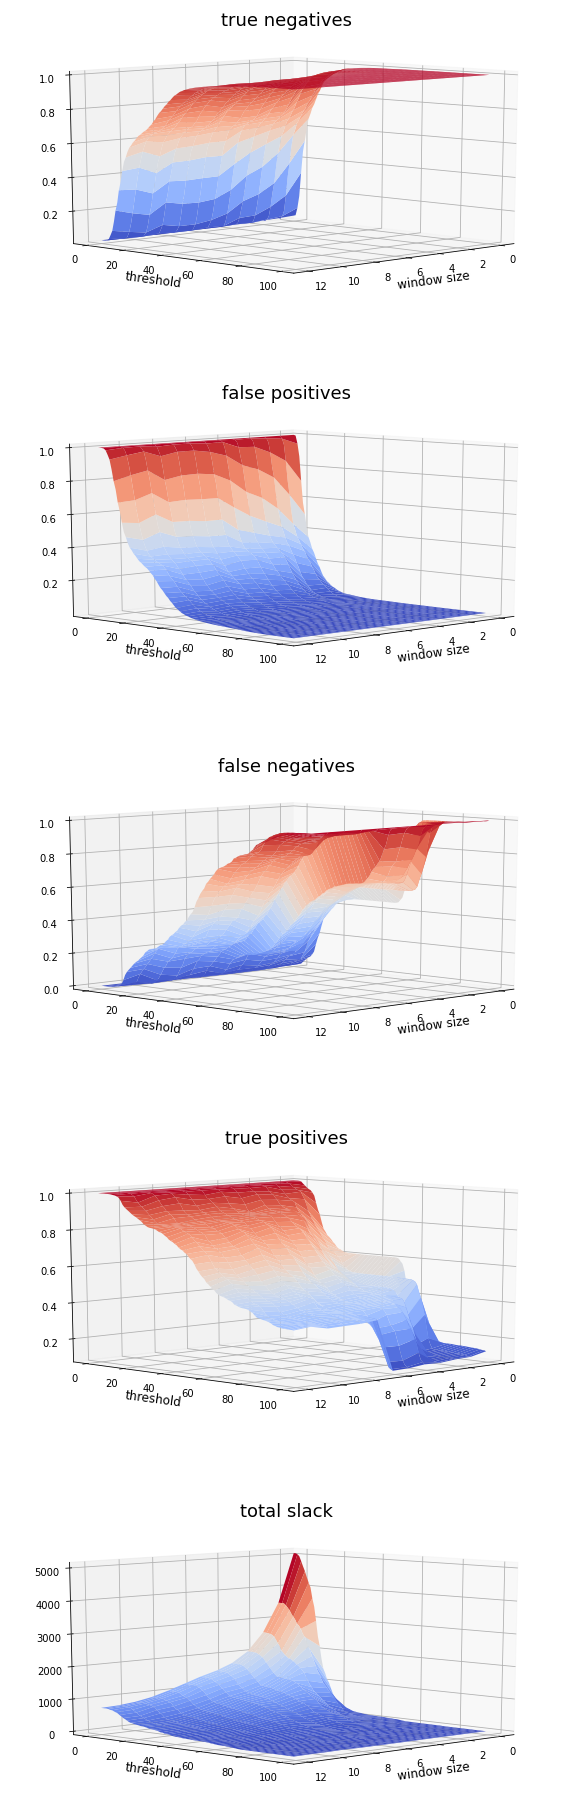

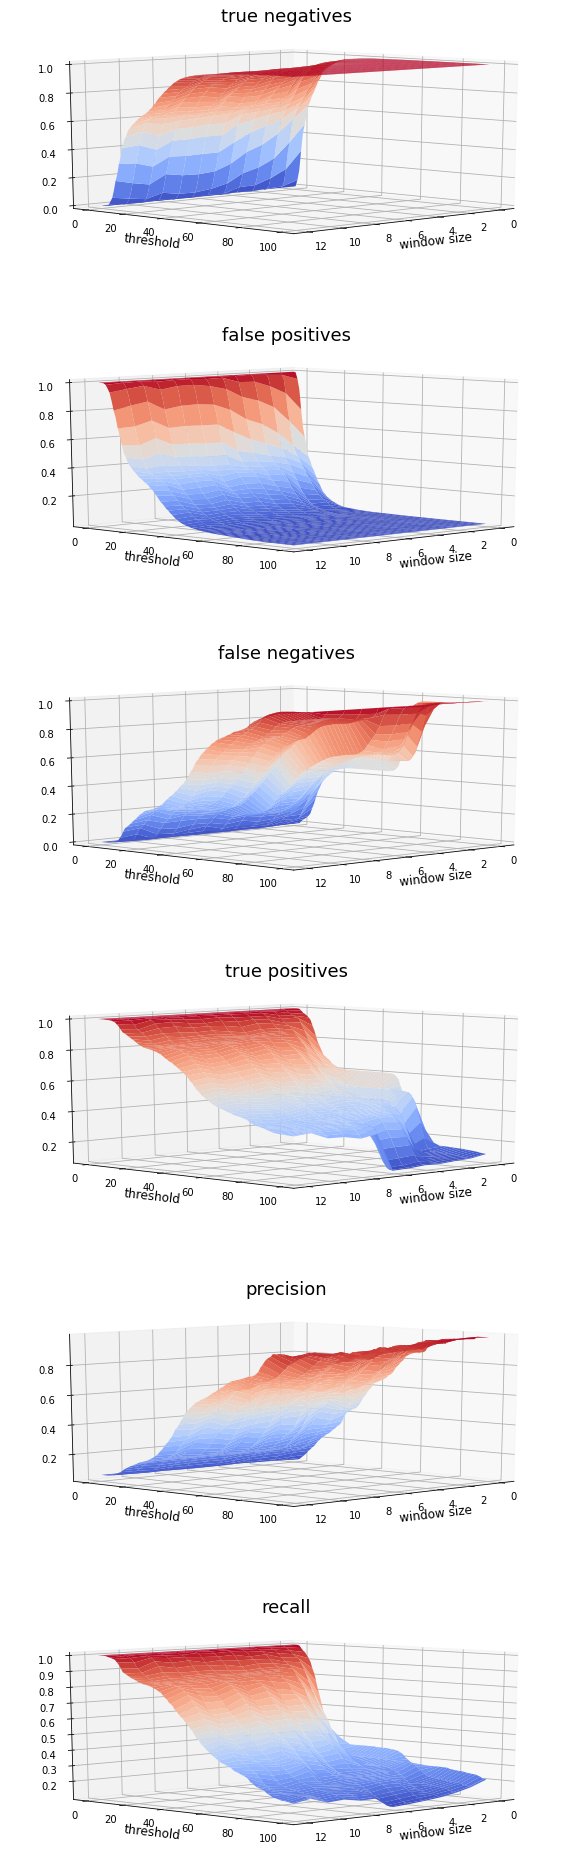

[[1.60606061e-01 3.01410000e+04 8.79254830e-01 4.20021692e-01]
 [9.39393939e-02 3.93998000e+04 8.93218311e-01 4.23449651e-01]
 [7.87878788e-02 3.53172000e+04 9.08518170e-01 4.80282147e-01]
 [9.09090909e-02 3.41870000e+04 9.21041015e-01 5.59558631e-01]
 [1.12121212e-01 3.33290000e+04 9.16570443e-01 5.74723703e-01]
 [1.09090909e-01 3.33656000e+04 9.12772489e-01 5.83203942e-01]
 [1.15151515e-01 3.33234000e+04 9.05001976e-01 5.86155658e-01]
 [1.27272727e-01 3.76062000e+04 9.07082132e-01 5.75022006e-01]
 [1.27272727e-01 3.55110000e+04 9.07298159e-01 6.07352073e-01]
 [1.21212121e-01 3.59992000e+04 8.98208892e-01 5.77595005e-01]
 [1.15151515e-01 3.53266000e+04 9.00374219e-01 5.91558211e-01]
 [1.30303030e-01 3.81200000e+04 8.91495321e-01 5.87079939e-01]
 [1.33333333e-01 3.81402000e+04 8.88707268e-01 5.95914603e-01]]


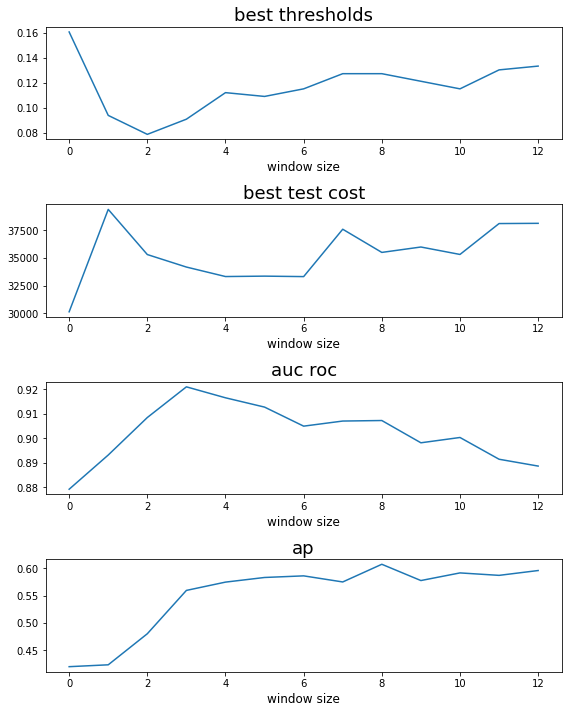

In [ ]:
#@title Random forest - window and threshold optimization

rf.global_win_search(search_range)

## Isolation forest

In [ ]:
#@title Isolation forest - fit

ifm = IsolationForestModel(None, train_data, val_data, test_data)
ifm.set_win_size(0)
ifm.fit()

epoch 1


100%|██████████| 217/217 [09:03<00:00,  2.51s/it]


validating...


100%|██████████| 12/12 [00:51<00:00,  4.27s/it]


epoch 2


100%|██████████| 217/217 [26:16<00:00,  7.27s/it]


validating...


100%|██████████| 12/12 [01:43<00:00,  8.62s/it]


epoch 3


100%|██████████| 217/217 [44:42<00:00, 12.36s/it]


validating...


100%|██████████| 12/12 [02:54<00:00, 14.57s/it]

early stopping


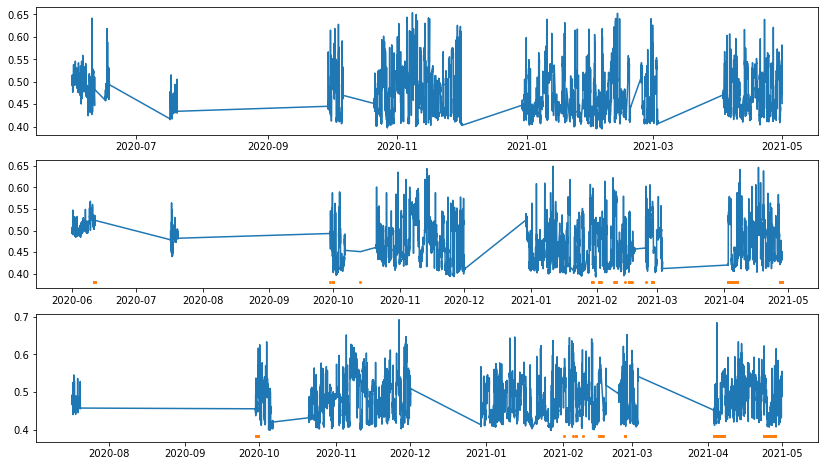

Validation signal range from 0.3928882111257939 to 0.6484676510034899


In [ ]:
#@title Isolation forest - threshold search on sample

min_signal, max_signal = ifm.plot_sample_signal(
    train_data[0], val_data[0], test_data[0])

print(f"Validation signal range from {min_signal} to {max_signal}")

Best threshold: 0.6565656565656566
Cost on the training set: 0.0
Cost on the validation set: 2900.0
Cost on the test set: 5851.0
avg AUC ROC: 0.5809990814073156, avg AP: 0.029753365500788536


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


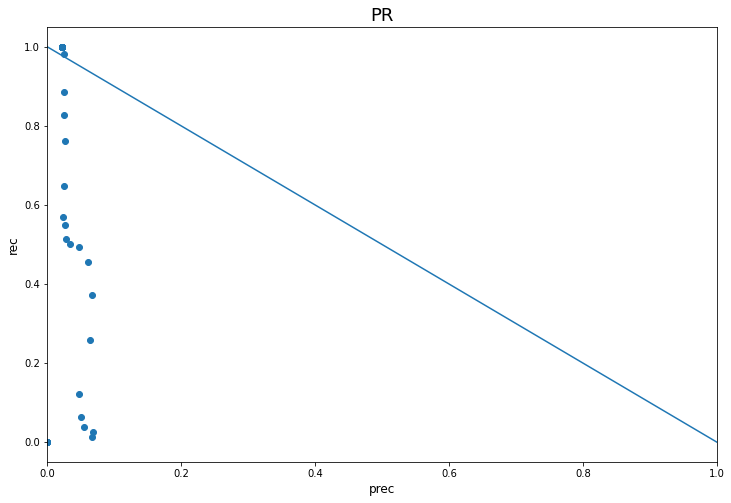

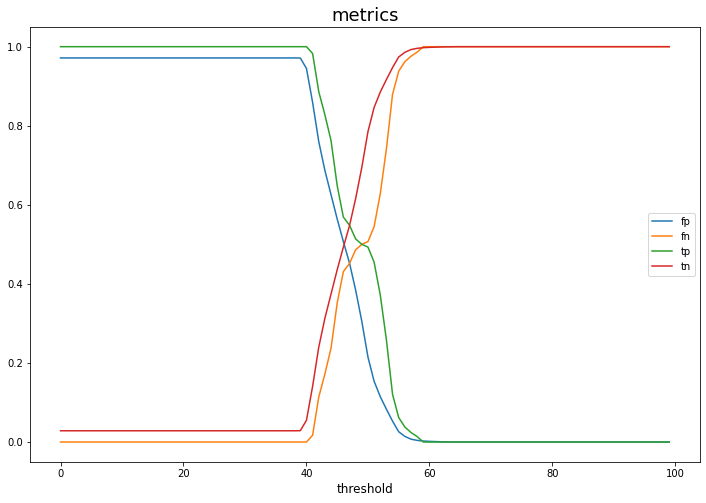

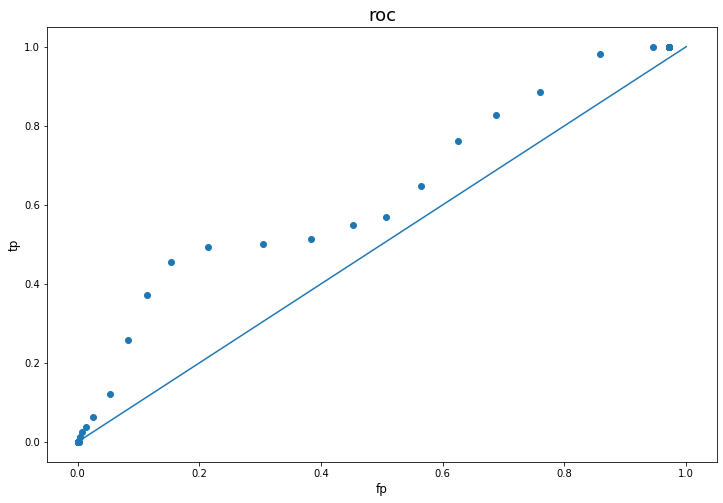

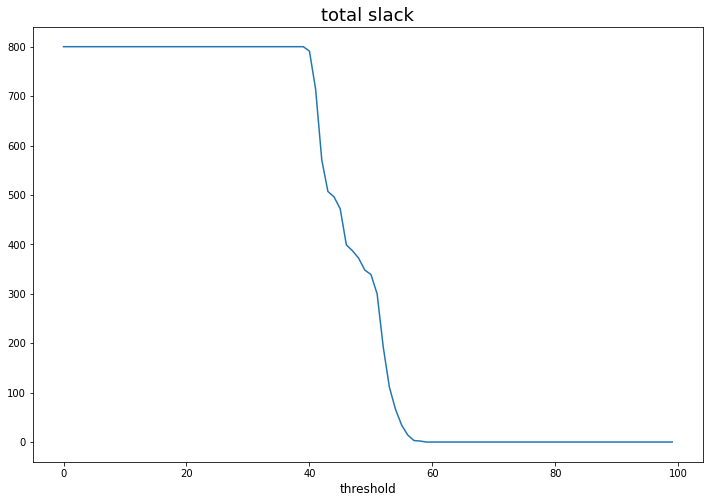

In [ ]:
#@title Isolation forest - threshold search on sample

search_range = np.linspace(0,1,100)

ifm.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

100%|██████████| 13/13 [2:42:12<00:00, 748.64s/it]


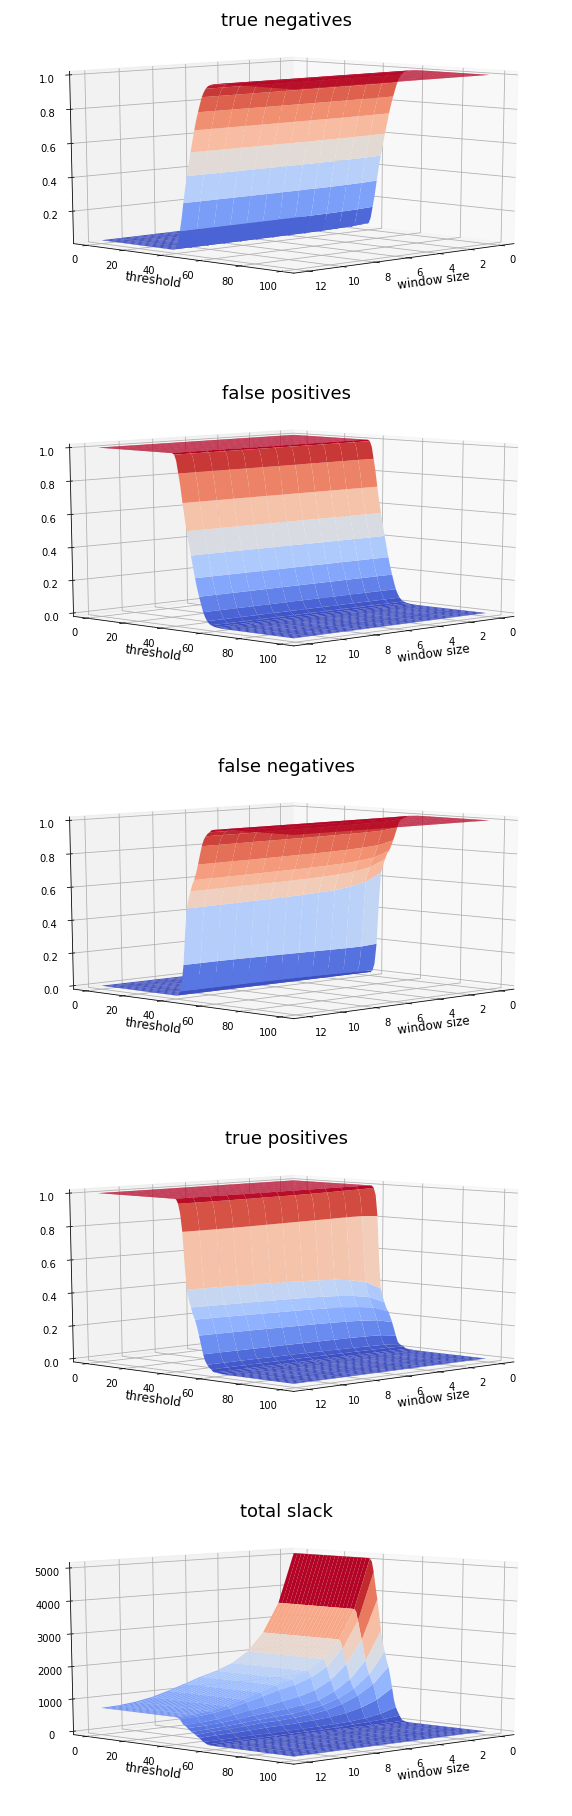

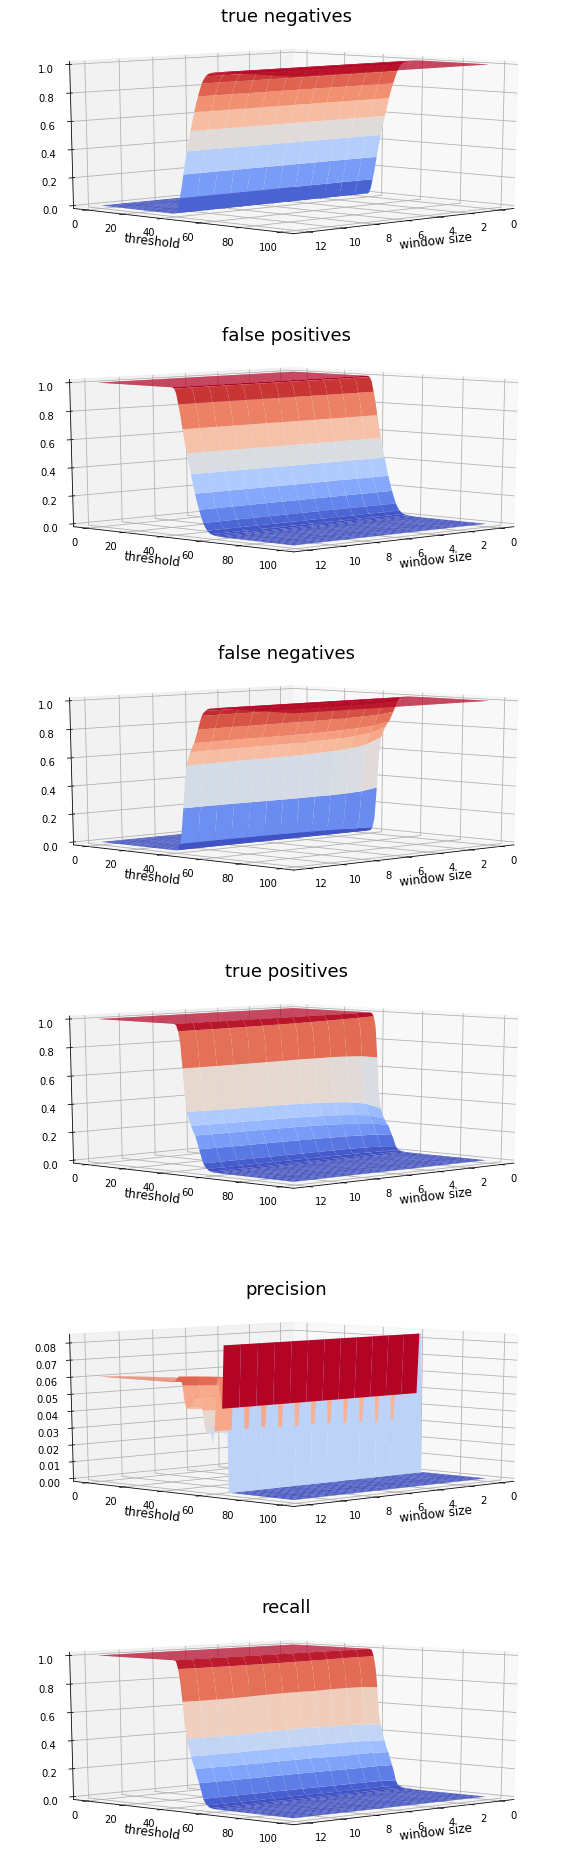

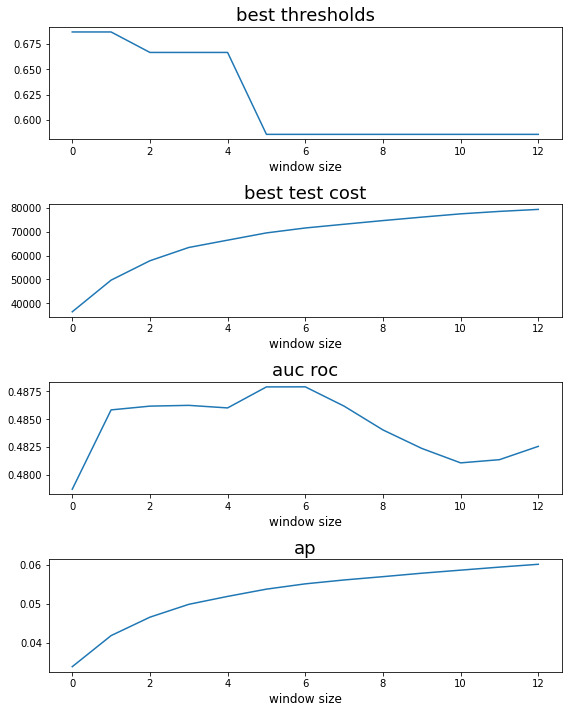

In [ ]:
#@title Isolation forest - window and threshold optimization

ifm.global_win_search(search_range)

## Gradient boosted trees

In [ ]:
#@title Gradient boost - fit

gb = GradientBoostedTrees(None, train_data, val_data, test_data)
gb.set_win_size(0)
gb.fit()

100%|██████████| 11/11 [19:41<00:00, 107.43s/it]


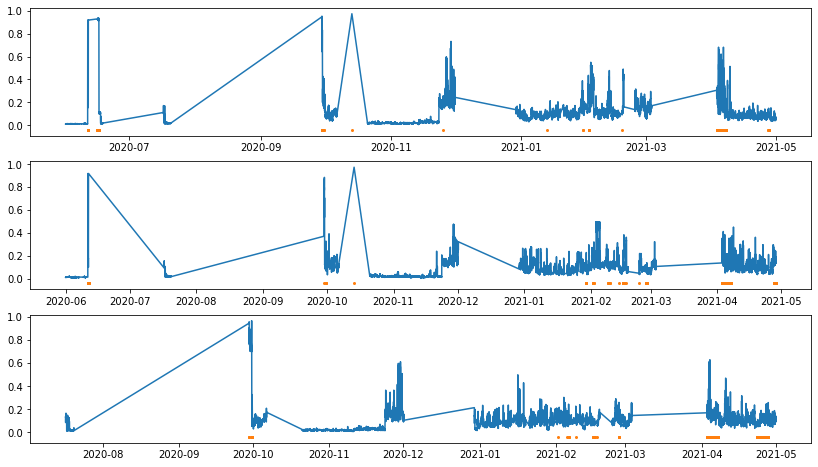

Validation signal range from 0.005604812317748071 to 0.9731999718632173


In [ ]:
#@title Gradient boost - threshold search on sample

min_signal, max_signal = gb.plot_sample_signal(
    train_data[0], val_data[0], test_data[0])

print(f"Validation signal range from {min_signal} to {max_signal}")

Best threshold: 0.17171717171717174
Cost on the training set: 1880.0
Cost on the validation set: 2101.0
Cost on the test set: 5137.0
avg AUC ROC: 0.8101072832029143, avg AP: 0.1454030548450731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


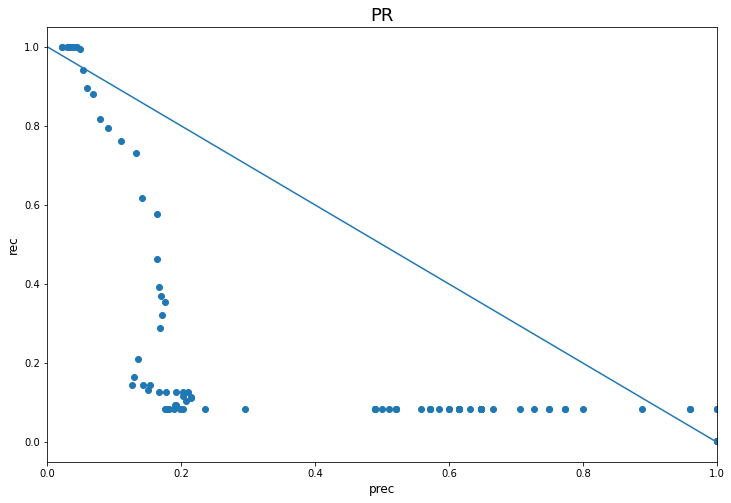

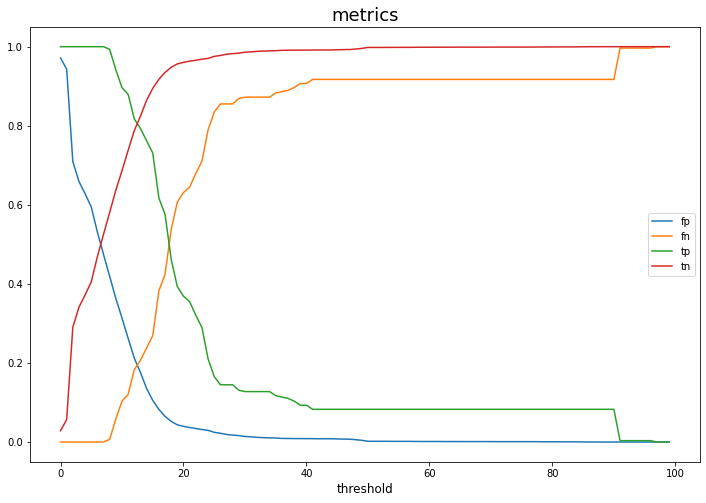

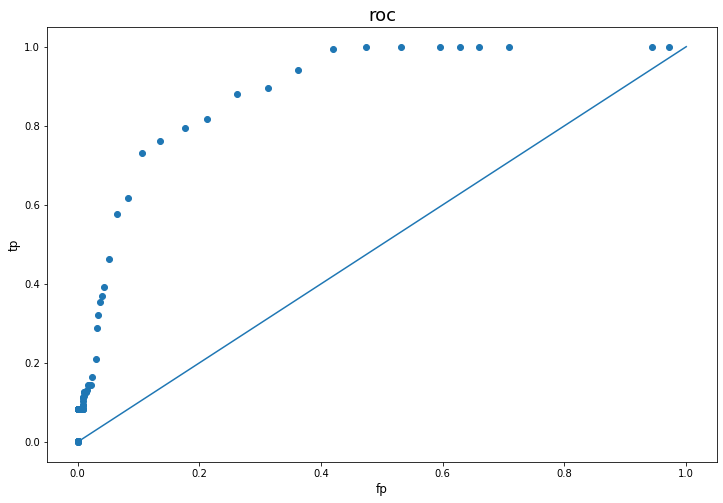

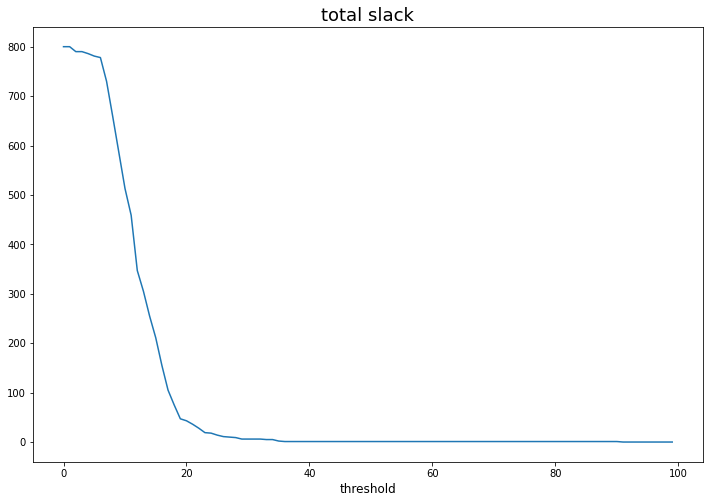

In [ ]:
#@title Gradient boost - threshold search on sample

search_range = np.linspace(0,1,100)

gb.sample_threshold_search(
    train_data[0], val_data[0], test_data[0], search_range)

100%|██████████| 13/13 [6:22:02<00:00, 1763.27s/it]


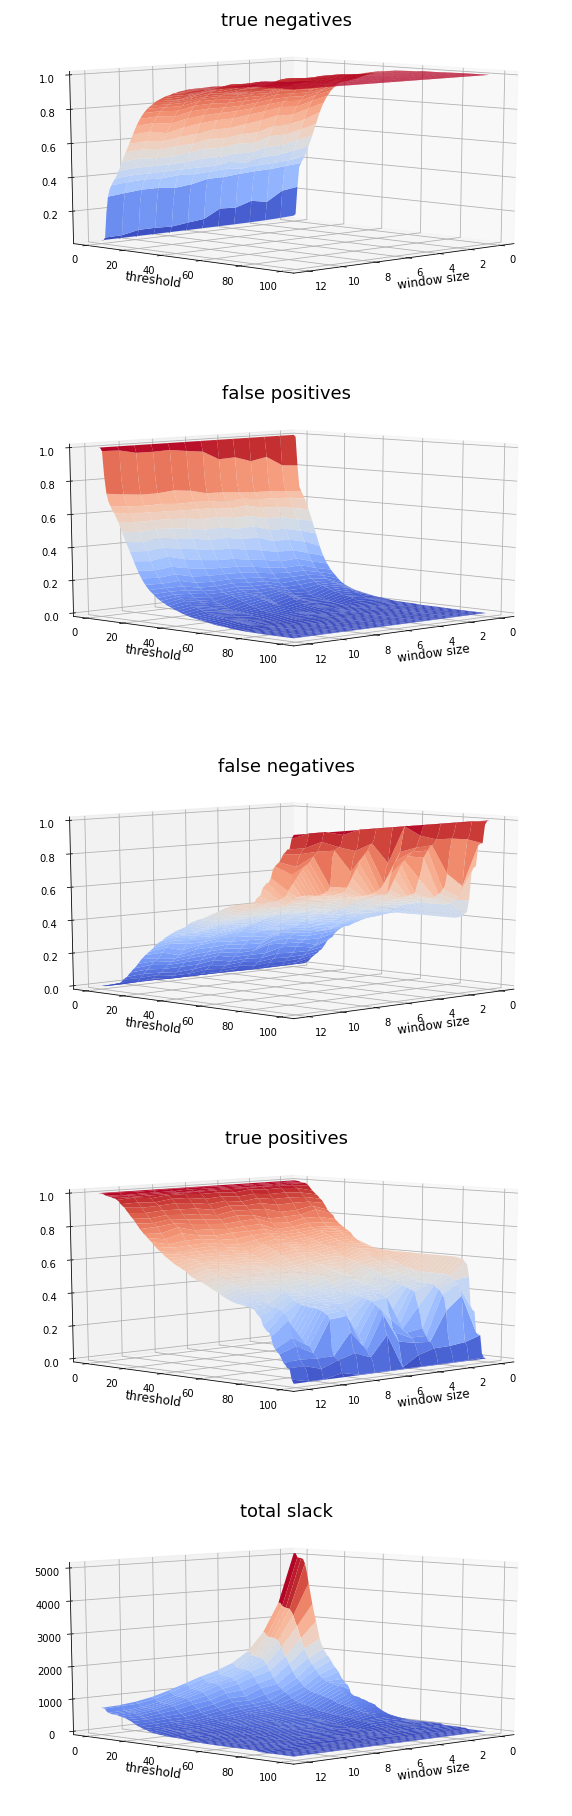

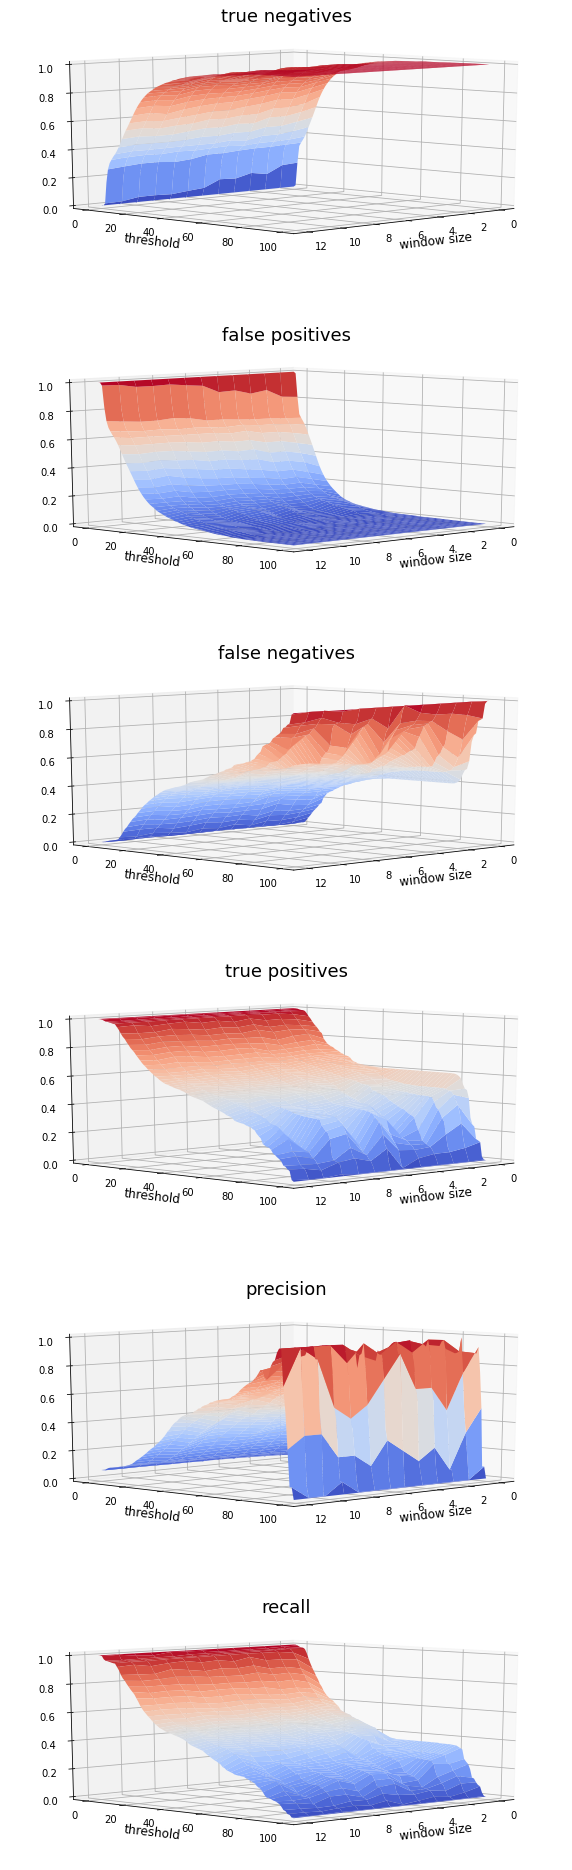

[[8.38383838e-01 3.17474000e+04 8.14031823e-01 3.47537231e-01]
 [5.25252525e-01 4.04604000e+04 8.61065868e-01 3.89650104e-01]
 [5.15151515e-01 4.63096000e+04 8.58332918e-01 4.34159991e-01]
 [3.73737374e-01 4.32660000e+04 8.59354422e-01 3.87096902e-01]
 [4.04040404e-01 4.72230000e+04 8.55820188e-01 4.27622823e-01]
 [4.34343434e-01 5.10260000e+04 8.52237015e-01 4.39134148e-01]
 [4.24242424e-01 5.26500000e+04 8.46692565e-01 4.08074726e-01]
 [2.62626263e-01 5.86876000e+04 8.34371016e-01 3.72312367e-01]
 [2.82828283e-01 5.19646000e+04 8.32945659e-01 4.14450673e-01]
 [3.63636364e-01 5.54208000e+04 8.44638802e-01 4.13682224e-01]
 [3.93939394e-01 5.64550000e+04 8.30048068e-01 4.00281716e-01]
 [4.64646465e-01 5.85096000e+04 8.28508806e-01 4.11973080e-01]
 [3.33333333e-01 5.69568000e+04 8.27806783e-01 3.79804199e-01]]


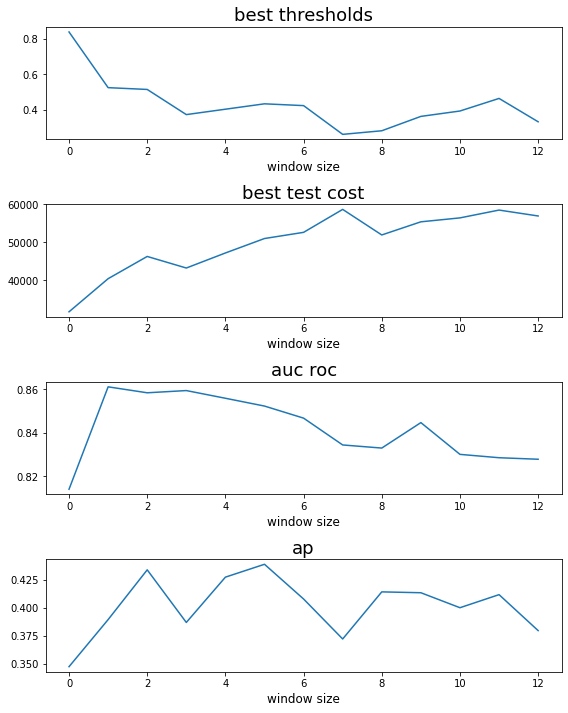

In [ ]:
#@title Gradient boost - window and threshold optimization

gb.global_win_search(search_range)

# Best model

In [ ]:
#@title MLP - win_size=6 - 10 epochs

mlp = MLP(batch_size, train_data, val_data, test_data)
mlp.set_win_size(6)
mlp.fit(10)

In [ ]:
th_range = np.linspace(0,1,100)

mlp.global_threshold_search(th_range)

In [ ]:
#@title Transformer - win_size=6 - 10 epochs

transformer = Transformer(batch_size, train_data, val_data, test_data)
transformer.set_win_size(6)
transformer.fit(10)

In [ ]:
th_range = np.linspace(0,1,100)

transformer.global_threshold_search(th_range)

# Other experiments

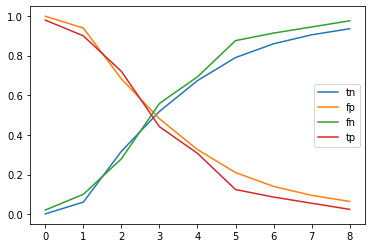

In [27]:
#@title DBSCAN

from sklearn.cluster import DBSCAN

metrics = np.zeros((9, 4))
for i in range(9):
    clustering = DBSCAN(eps=i+1, min_samples=10)
    clustering = clustering.fit(train_data[0][FEATURES])
    preds = pd.Series(index=train_data[0].index, data=clustering.labels_)
    preds[preds != -1] = 0
    preds[preds == -1] = 1
    tn, fp, fn, tp = confusion_matrix(generate_window(train_data[0], 0), preds).ravel()
    metrics[i] = np.array([tn, fp, fn, tp])

n = len(train_data[0].query("New_label == 0"))
p = len(train_data[0]) - n

plt.plot(metrics[:,0]/n)
plt.plot(metrics[:,1]/n)
plt.plot(metrics[:,2]/p)
plt.plot(metrics[:,3]/p)
plt.legend(['tn', 'fp', 'fn', 'tp'])

## Sequence classfication

In [28]:
#@title Sequence data loader

class SequenceDataGenerator(Sequence):
    def __init__(self, nodes, batch_size, seq_len, win_size):
        self.nodes = nodes
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.win_size = win_size
        self._gen = self._generator()

    def _contiguous_data(self, node):
        deltas = node.index[1:] - node.index[:-1]
        bool_list = deltas == pd.Timedelta('15min')
        subseq = np.split(node, np.argwhere(bool_list == False).flatten()+1)
        return subseq

    def __len__(self):
        tot_len = 0
        for node in self.nodes:
            chunks = self._contiguous_data(node)
            for c in chunks:
                tot_len += len(c)//(self.batch_size*self.seq_len)
        return tot_len-1

    def _generator(self):
        for node in self.nodes:
            chunks = self._contiguous_data(node)
            for c in chunks:
                y = generate_window(c, self.win_size)                    
                for j in range(len(c)//(self.batch_size*self.seq_len)):
                    offset = j*self.batch_size
                    batchX = np.empty((self.batch_size, self.seq_len, len(FEATURES)))
                    batchY = np.empty((self.batch_size, 1))

                    for i in range(self.batch_size):
                        batchX[i] = c.iloc[offset+i*self.seq_len:
                                        offset+(i+1)*self.seq_len][FEATURES].to_numpy()

                        batchY[i,0] = 1 if np.sum(y[offset+(i+1)*self.seq_len-1]) > 0 else 0
                    yield batchX, batchY

    def __getitem__(self, index):
        return next(self._gen)

    def on_epoch_end(self):
        self._gen = self._generator()

In [29]:
#@title Sequence model

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class SequenceEncoder(tf.keras.layers.Layer):
    def __init__(self, seq_len, num_layers = 4, d_model = 512, num_heads = 8, 
                dff = 2048,dropout = 0.0):
        super(SequenceEncoder, self).__init__()
        self.d_model = d_model
        self.encoder_layers = [ 
            EncoderLayer(d_model = d_model, num_heads = num_heads, 
                            dff = dff, dropout = dropout) 
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.dim_adapter = layers.Dense(self.d_model, activation='relu')
        self.pos_encoding = positional_encoding(seq_len, self.d_model)

    def call(self, inputs, mask=None, training=None):
        x = self.dim_adapter(inputs)
        x += self.pos_encoding
        x = self.dropout(x, training=training)
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

def build_transformer_model(seq_len):
    input_shape = (seq_len, len(FEATURES))
    num_layers = 2
    d_model = 256
    dff = 512
    num_heads = 4
    dropout_rate = 0.5

    x = keras.Input(shape=input_shape, dtype='float32')
    z = SequenceEncoder(seq_len, num_layers = num_layers, d_model = d_model, 
                num_heads = num_heads, dff = dff, 
                dropout = dropout_rate)(x)
    z = layers.Reshape((1,d_model*seq_len))(z)
    y = layers.Dense(1, activation="sigmoid")(z)
    model = keras.Model(x, y)

    optimizer = tf.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])
    return model


def build_lstm_model(seq_len):
    input_shape = (seq_len, len(FEATURES))

    x = keras.Input(shape=input_shape, dtype='float32')
    z = tf.keras.layers.LSTM(256,return_sequences=True, dropout=0.6)(x)
    z = tf.keras.layers.LSTM(128,return_sequences=False, dropout=0.6)(z)
    y = layers.Dense(1, activation="sigmoid")(z)
    model = keras.Model(x, y)

    optimizer = tf.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])
    return model

In [30]:
seq_len = 8
batch_size = 8 
win_size = 0

mdl = build_lstm_model(seq_len)

train = SequenceDataGenerator(train_data, batch_size, seq_len, win_size)
val = SequenceDataGenerator(val_data+test_data, batch_size, seq_len, win_size)

cb = [callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
hstory = mdl.fit(train, validation_data=val, callbacks=cb, 
                 class_weight={0:1, 1:14.28},
                batch_size=batch_size, epochs=10, verbose=1)

Epoch 1/10
44467/44467 [==============================] - 876s 19ms/step - loss: 0.9182 - false_negatives: 4687.0000 - true_positives: 21937.0000 - false_positives: 76584.0000 - true_negatives: 252528.0000 - val_loss: 0.5057 - val_false_negatives: 259.0000 - val_true_positives: 2111.0000 - val_false_positives: 9457.0000 - val_true_negatives: 25333.0000
Epoch 2/10
44467/44467 [==============================] - 862s 19ms/step - loss: 0.8131 - false_negatives: 3770.0000 - true_positives: 22854.0000 - false_positives: 68372.0000 - true_negatives: 260740.0000 - val_loss: 0.4598 - val_false_negatives: 288.0000 - val_true_positives: 2082.0000 - val_false_positives: 8570.0000 - val_true_negatives: 26220.0000
Epoch 3/10
44467/44467 [==============================] - 859s 19ms/step - loss: 0.7730 - false_negatives: 3650.0000 - true_positives: 22974.0000 - false_positives: 63424.0000 - true_negatives: 265688.0000 - val_loss: 0.4119 - val_false_negatives: 429.0000 - val_true_positives: 1941.0000 -